In [28]:
import netCDF4 as nc
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader

In [29]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

In [30]:
#Identify scanline in groundpixel 224 with clouds
scanline = africa.variables['scanline']
groundpixel = africa.variables['ground_pixel']

#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud = []
for n in range(406):
    if (africa.variables['CloudFraction'][0,n,224:240]<0.4).all():
        scanline_nocloud.append(n)

In [31]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 4 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), 195))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

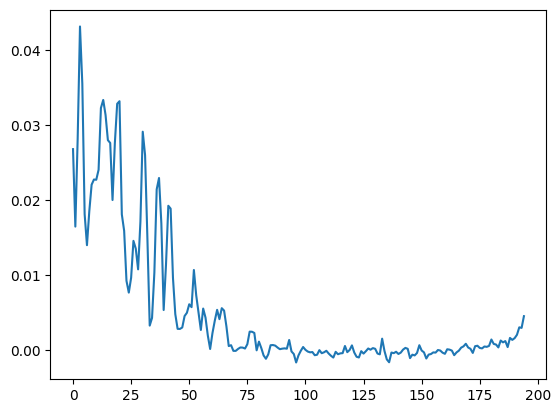

In [32]:
plt.plot(-(africa.variables["Reflectance"][0, scanline_nocloud, 224, ind] - surf_albedo)[0])

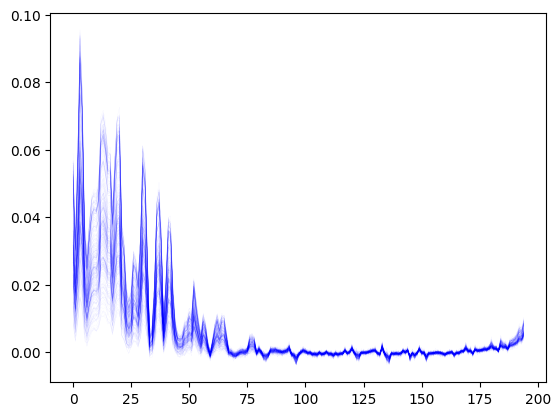

In [33]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,224]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,224]))
mu_matrix = np.tile(mu[:, np.newaxis], 195)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 195)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 224, 276:471].data
angles = (mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix
tau = -np.log(reflectance_matrix/surf_albedo)/angles
for idx, i  in enumerate(scanline_nocloud):
    plt.plot(tau[idx],color='blue', alpha=0.1, linewidth=0.1)
    #what is the unit?? 
plt.show()

In [12]:
train_dataset = torch.tensor(tau[0:280], dtype=torch.float32)
test_dataset = torch.tensor(tau[280:317], dtype=torch.float32)
print("Train dataset shape:", train_dataset.shape)
print("Test dataset shape:", test_dataset.shape)
# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Train dataset shape: torch.Size([280, 195])
Test dataset shape: torch.Size([37, 195])


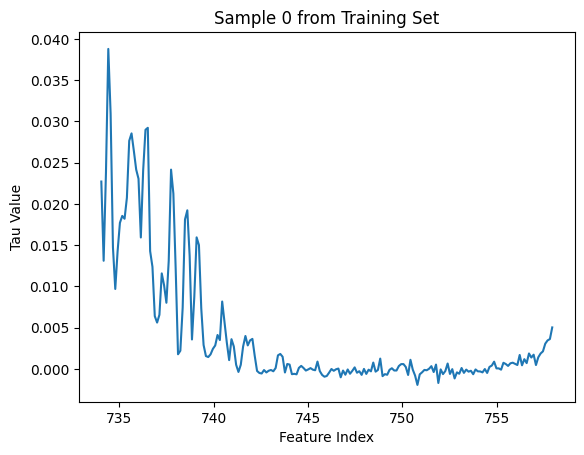

In [13]:
##VISUALISE SOME TRANING DATA 
tau_batch = next(iter(train_loader))

# Select a sample to plot (first one in the batch)
sample_index = 0
tau_sample = tau_batch[sample_index].squeeze()  # Shape (406,)


plt.plot(wl[ind],tau_sample.detach())
plt.xlabel("Feature Index")
plt.ylabel("Tau Value")
plt.title(f"Sample {sample_index} from Training Set")
plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=195, latent_dim=10):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=195, latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')  # Use MSE for continuous data
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

# Training function
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):  # Fix unpacking issue
            x = x[0].to(device)  # Extract tensor from dataset

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {overall_loss / len(train_loader)}")

# Train model
train(model, optimizer, epochs=5000, device=device)


Epoch [500/5000], Average Loss: 0.14421621958414713
Epoch [1000/5000], Average Loss: 0.03024008870124817
Epoch [1500/5000], Average Loss: 0.010664527770131826
Epoch [2000/5000], Average Loss: 0.006701298019227882
Epoch [2500/5000], Average Loss: 0.0022045231889933348
Epoch [3000/5000], Average Loss: 0.009795339758663127
Epoch [3500/5000], Average Loss: 0.0018039611556256812
Epoch [4000/5000], Average Loss: 0.002429953582274417
Epoch [4500/5000], Average Loss: 0.0017154576586714636
Epoch [5000/5000], Average Loss: 0.0016632165934424847


In [82]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon, _, _ = model(data)
        
        # Number of samples to plot
        num_samples = min(3, len(data))
        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
        for j in range(num_samples):
            axes[0, j].plot(data[j].cpu().numpy(), label='Original')
            axes[0, j].set_title(f'Original Function {j+1}')
            axes[0, j].legend()
            
            axes[1, j].plot(recon[j].cpu().numpy(), label='Reconstructed', color='orange')
            axes[1, j].set_title(f'Reconstructed Function {j+1}')
            axes[1, j].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Break after the first batch
        break


ValueError: not enough values to unpack (expected 3, got 2)

In [106]:
#EVP-AE
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class EVPAutoencoder(nn.Module):
    def __init__(self, input_dim=195, latent_dim=20):
        super(EVPAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.LeakyReLU(0.01),
            nn.Linear(50, latent_dim) # No activation to allow negative values
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.LeakyReLU(0.01),
            nn.Linear(50, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EVPAutoencoder(input_dim=195, latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def loss_function(x, x_hat, z):
    #Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    if z.dim() == 1:  # Handle edge case where z is 1D (e.g., batch_size=1)
        z = z.unsqueeze(0)  # Reshape to [1, latent_dim]
    # Orthogonality loss (for latent vectors)
    z_normalized = z / torch.norm(z, dim=1, keepdim=True)  # Unit vectors
    dot_product = torch.matmul(z_normalized.T, z_normalized)  # [latent_dim, latent_dim]
    identity = torch.eye(z.size(1), device=device)
    ortho_loss = torch.norm(dot_product - identity, p='fro')  # Frobenius norm
    
    # Combined loss
    lambda_ortho = 0.01  # Weight for orthogonality (tune as needed)
    total_loss = recon_loss + lambda_ortho * ortho_loss
    return total_loss 

def train(model, optimizer, data_loader, epochs=5000):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            x = batch[0].to(device)  # Assuming batch shape [batch_size, 195]
            optimizer.zero_grad()
            x_hat, z = model(x)
            loss = loss_function(x, x_hat, z)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(data_loader):.4f}")

# Example data loader (replace with your data)
train(model, optimizer, train_loader, epochs=5000)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAjAAAAGdCAYAAAAMm0nCAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAc5ZJREFUeJzt3Xl4VOXZP/DvmT0JWSAhCYFA2Pd9icFdI8FiFW0R0QoitdWKpdLys/gq2NoWra8UfaFSrVSqokir2CrFQhRECTvIvi8JhMlK9mTW8/tj5pxZMnsmk0zy/VwXlzA5MzlDhHy5n/u5H0EURRFEREREUUTR1jdAREREFCwGGCIiIoo6DDBEREQUdRhgiIiIKOowwBAREVHUYYAhIiKiqMMAQ0RERFGHAYaIiIiijqqtbyAcrFYriouLER8fD0EQ2vp2iIiIKACiKKK2thYZGRlQKIKrqXSIAFNcXIzMzMy2vg0iIiIKQVFREXr16hXUczpEgImPjwdg+w1ISEho47shIiKiQNTU1CAzM1P+Ph6MDhFgpGWjhIQEBhgiIqIoE0r7B5t4iYiIKOowwBAREVHUYYAhIiKiqMMAQ0RERFGHAYaIiIiiDgMMERERRR0GGCIiIoo6DDBEREQUdRhgiIiIKOowwBAREVHUYYAhIiKiqMMAQ0RERFGHAYaIiIiiDgMMERERRR0GGCIiIoo6DDBEREQUdRhgiIiIKOowwBAREVHUYYAhIiKiqMMAQ0RERFGHAYaIiIiiDgMMERERRR0GGCIiIoo6DDBEREQUdRhgiIiIKOowwBAREVHUYYAhIiKiqMMA0wIHC6/hu6Kqtr4NIiKiTocBJkQGswUPvrUbD/11N0wWa1vfDhERUafCABOiBoMFjSYL6gxm1BvMbX07REREnQoDTIhMVkfVpdFkacM7ISIi6nwYYEJksojyzxuMDDBERESRxAATIrNT30sjAwwREVFEMcCEyLkCwyUkIiKiyGKACZGJFRgiIqI2wwATIjN7YIiIiNpMSAFm1apVyMrKgk6nQ3Z2Nvbs2ePz+g0bNmDIkCHQ6XQYOXIkNm3a1OyaEydO4O6770ZiYiLi4uIwceJEFBYWhnJ7EWF0qsA0cQmJiIgoooIOMOvXr8fChQuxdOlSHDhwAKNHj0ZeXh5KS0s9Xr9z507MmjUL8+bNw8GDBzF9+nRMnz4dR48ela85d+4cbrjhBgwZMgTbtm3D4cOH8fzzz0On04X+zlqZcxMvKzBERESRJYiiKPq/zCE7OxsTJ07EypUrAQBWqxWZmZl46qmn8Otf/7rZ9TNnzkR9fT0+++wz+bHrrrsOY8aMwerVqwEADzzwANRqNd59992Q3kRNTQ0SExNRXV2NhISEkF4jWN+eLcdDf90NAHj+rmGYd0PfiHxeIiKijqIl37+DqsAYjUbs378fubm5jhdQKJCbm4uCggKPzykoKHC5HgDy8vLk661WKz7//HMMGjQIeXl5SE1NRXZ2NjZu3Oj1PgwGA2pqalx+RJrRpYmXk3iJiIgiKagAU15eDovFgrS0NJfH09LSoNfrPT5Hr9f7vL60tBR1dXV46aWXMHXqVPz3v//Fvffei/vuuw/bt2/3+JrLli1DYmKi/CMzMzOYtxEWZm6jJiIiajNtvgvJah/Jf8899+Dpp5/GmDFj8Otf/xp33XWXvMTkbvHixaiurpZ/FBUVRfKWAbhuo2YPDBERUWSpgrk4JSUFSqUSJSUlLo+XlJQgPT3d43PS09N9Xp+SkgKVSoVhw4a5XDN06FB88803Hl9Tq9VCq9UGc+thZ+IuJCIiojYTVAVGo9Fg/PjxyM/Plx+zWq3Iz89HTk6Ox+fk5OS4XA8AW7Zska/XaDSYOHEiTp065XLN6dOn0adPn2BuL6I4B4aIiKjtBFWBAYCFCxdizpw5mDBhAiZNmoQVK1agvr4ec+fOBQDMnj0bPXv2xLJlywAACxYswM0334xXX30V06ZNw4cffoh9+/bhzTfflF9z0aJFmDlzJm666Sbceuut2Lx5M/79739j27Zt4XmXrYCTeImIiNpO0AFm5syZKCsrw5IlS6DX6zFmzBhs3rxZbtQtLCyEQuEo7EyePBnr1q3Dc889h2effRYDBw7Exo0bMWLECPmae++9F6tXr8ayZcvw85//HIMHD8Y///lP3HDDDWF4i63DZGUTLxERUVsJeg5Me9QWc2DWfHMBv/3sOABgQp+u+McTkyPyeYmIiDqKiM2BIQezlbuQiIiI2goDTIhMTk283IVEREQUWQwwIeIcGCIiorbDABMiTuIlIiJqOwwwIeI2aiIiorbDABMi5x4Yo8UKs1OgISIiotbFABMi511IAJeRiIiIIokBJkQmCwMMERFRW2GACZHzEhLAPhgiIqJIYoAJESswREREbYcBJkRmtwoMZ8EQERFFDgNMiNwrME0MMERERBHDABMi9wDDCgwREVHkMMCEyGx1a+JlDwwREVHEMMCEyGh2a+JlBYaIiChiGGBCJFVg1EoBACswREREkcQAEyLp6IAEnRoAe2CIiIgiiQEmREb7NuqEGFuAaTSa2/J2iIiIOhUGmBBJFZh4nQoAl5CIiIgiiQEmRCYuIREREbUZBpgQmeQlJFZgiIiIIo0BJkRmq2sFhtuoiYiIIocBJkQm9yZeVmCIiIgihgEmRI4eGNsSEntgiIiIIocBJkRygLFXYJpYgSEiIooYBpgQmaUlJO5CIiIiijgGmBCIoigfJSDvQmKAISIiihgGmBBIDbyA0y4kLiERERFFDANMCKQt1AAQz23UREREEccAEwKT2akC4zTIzmoVvT2FiIiIwogBJgQmDxUYADCYrZ4uJyIiojBjgAmBtANJrRQQo1bKjzfwRGoiIqKIYIAJgTQDRqVQQKkQoFXZfhvZyEtERBQZDDAhkAOMUgAAxGhsVRg28hIREUUGA0wIpG3UGqXtty/WvozECgwREVFkMMCEwFsFhtN4iYiIIoMBJgTSFF61vQIjLyGxAkNERBQRDDAhkCowankJiccJEBERRRIDTAgcu5BsS0hate23kSdSExERRUZIAWbVqlXIysqCTqdDdnY29uzZ4/P6DRs2YMiQIdDpdBg5ciQ2bdrk8vFHHnkEgiC4/Jg6dWootxYRJovrEpIUZMycxEtERBQRQQeY9evXY+HChVi6dCkOHDiA0aNHIy8vD6WlpR6v37lzJ2bNmoV58+bh4MGDmD59OqZPn46jR4+6XDd16lRcvXpV/vHBBx+E9o4iwCwvIdmCi8oeZMwWBhgiIqJICDrALF++HI899hjmzp2LYcOGYfXq1YiNjcWaNWs8Xv/aa69h6tSpWLRoEYYOHYoXX3wR48aNw8qVK12u02q1SE9Pl3907do1tHcUAe4VGCnIOB/ySERERK0nqABjNBqxf/9+5ObmOl5AoUBubi4KCgo8PqegoMDlegDIy8trdv22bduQmpqKwYMH44knnkBFRYXX+zAYDKipqXH5EUnu26iVClZgiIiIIimoAFNeXg6LxYK0tDSXx9PS0qDX6z0+R6/X+71+6tSp+Pvf/478/Hy8/PLL2L59O+68805YLJ6bYpctW4bExET5R2ZmZjBvo8WkSotcgVGwAkNERBRJqra+AQB44IEH5J+PHDkSo0aNQv/+/bFt2zbcfvvtza5fvHgxFi5cKP+6pqYmoiHGZHZr4rVXYkyswBAREUVEUBWYlJQUKJVKlJSUuDxeUlKC9PR0j89JT08P6noA6NevH1JSUnD27FmPH9dqtUhISHD5EUkmq+s2ajbxEhERRVZQAUaj0WD8+PHIz8+XH7NarcjPz0dOTo7H5+Tk5LhcDwBbtmzxej0AXL58GRUVFejRo0cwtxcxUlBRq1y3UVu4hERERBQRQe9CWrhwId566y2sXbsWJ06cwBNPPIH6+nrMnTsXADB79mwsXrxYvn7BggXYvHkzXn31VZw8eRIvvPAC9u3bh/nz5wMA6urqsGjRIuzatQsXL15Efn4+7rnnHgwYMAB5eXlhepvhJU/ilSow9iZeE+fAEBERRUTQPTAzZ85EWVkZlixZAr1ejzFjxmDz5s1yo25hYSEUCkcumjx5MtatW4fnnnsOzz77LAYOHIiNGzdixIgRAAClUonDhw9j7dq1qKqqQkZGBqZMmYIXX3wRWq02TG8zvKReF5X7NmoLKzBERESREFIT7/z58+UKirtt27Y1e2zGjBmYMWOGx+tjYmLwxRdfhHIbbcb9LCQ28RIREUUWz0IKgfskXmkOjIVLSERERBHBABMCqdeFc2CIiIjaBgNMCExm10m8Ui8Ml5CIiIgigwEmBNKp02pF6zXxHr5chb99ewGiyFBERETkrl1M4o02RrcmXqW8hBSesCGKIuavO4jCygb0794FNw3qHtLrGMwWaFXKsNwTERFRe8IKTAjMFs9LSOGaxHumtA6FlQ0AgJP60A6qXL7lNEYs/QKfHS4Oyz0RERG1JwwwIZCCiqaVmnjzT5TKPz9XWh/081d9dRav55+BySLiYGFVWO6JiIioPWGACYHRSwUmXE28X550nB11tqwuqOd+sKcQr3xxSv41h+sREVFHxAATArPbJF7HWUgtDzDX6o3Yf+ma/OuzpXVBNfL+Zfs5AEB6gg4AYOTOKCIi6oAYYEIgTeLVyBUYweXxlth+ugxWEeiXEgdBAKobTaioNwb8/Er7tTcOTAHACgwREXVMDDAhkAbZSYc4Sv8Nxy6k/JO2/pc7R6ajV9cYALYqTCCsVhG1BjMAoFsXje1eGWCIiKgDYoAJgXyUgCq8c2BMFiu2n7IFmNuGpGJA9y4AgHMB9sHUGc2QVpuS4+wBhscbEBFRB8QAEwL5MEeFdBZSeObAXLnWiJomM3RqBcZkdkV/e4AJtAJT22SrvmhUCsRpbSN+pKnBREREHQkDTAhMbk286jDNgWkwWgAA8To1lAoBA1KlCkxgW6lrGk0AgASd2nFPrMAQEVEHxAATApPbadTSLiRTC+fANJpsASZGbZue218KMAFWYBwBRiXfG3tgiIioI2KACYFUaZGqHCq5B6Zl1Y4mtwAj9cBcqWpEvb051xdpCSk+xlGBYYAhIqKOiAEmBFKlRQ4w9l1ILZ0D02hfQtJpbAGma5xGbsa9UO5/GammyVGBke6JJ2QTEVFHxAATAlOzSbzhWa5xLCE5vizBNPI698BoVOE/IZuIiKi9YIAJgbyEpHBr4m1pBcZtCQlw9MEEEmCkJaSEGEcFhpN4iYioI2KACYHcxKty3Ubd0gqM3AOjcQSYrORYALY+GH8cS0hOu5BYgSEiog6IASYE8jZqqQIT7h4YpwpMaoIWAFBa2+T3+TWN9iZe7kIiIqIOjgEmBGb5LKTw7kLytITUvYvtUMayWoPf58sVGJddSFxCIiKijocBJgSOQXZuTbxhngMDOFdg/AcYuQdGpw7rAZNERETtDQNMkERRlIOKHGDsS0ii2LJlpCZj8x6Y7l1sAaaqwQSD2eLz+VIFJl6nkqtDnMRLREQdEQNMkCxWUT4w0X0JCQDMLajCSBUY5x6YpFi13M9SXmf0+Xx5G3WMWj7mgGchERFRR8QAEyTnioZ8FpLC8dvYkj6YRpMtbDgvIQmCIFdh/PXBOC8hqcO0rEVERNQeMcAEybmnRO3WAwO0MMB4WEICgO4Jtkbe0hrvO5FEUXRq4lWxiZeIiDo0BpggOQcCqfIiHeYItKzi4X4WkkSuwNR5r8A0mazyvcU7zYGxWEVY2QdDREQdDANMkKQt1AoBUNiDiyAI8jC7ljTxeuqBAZx2ItV4DzBS9UUhAHEapUtViMtIRETU0TDABMlocT3IUaIKwzRer0tIAVRgap1mwAiCIDcYAy2fT0NERNTeMMAEST4HyS3AOEb3t2AbtZclpEAqMNVOU3gBt2UtzoIhIqIOhgEmSNI2abXTEg3gOA+pJXNXPA2yAwKrwDifgyTdj2C/RTbyEhFRR8MAEySjWZrC616BkQJMy+fAxGhcXzvVvgupzMcuJOct1ICtL0dqMmYFhoiIOhoGmCDJFRiFawVGmsYbjm3U7k283eMdFRhR9Pz60hA7aQkJcApVrMAQEVEHwwATJKmaoVa5NfG28Owhq1WEwdx8kB0ApHTR2F9bRFWDyePznQ9ydNyT7R6NrVCBuVheLwcuIiKiSGOACZJ8kGOzCkzLtlE3OZ1z5L4LSatSIinWFky89cG4LyEBTo3FYd5GfeJqDW75321Y+NGhsL4uERFRoBhgguRtF5KqhZNvnasZOpWy2celRl5vO5F8LSGZzOFdQrpUUQ8AOFpcHdbXJSIiChQDTJBMfubAhFrtkBp4tSqFPCDPmbSVuqzOcyNvjVSBiWlegQn3IDtpqaukxntPDhERUWsKKcCsWrUKWVlZ0Ol0yM7Oxp49e3xev2HDBgwZMgQ6nQ4jR47Epk2bvF77+OOPQxAErFixIpRba3VSgFG5baNu6RwYeQaMpnn1BQi8ApPgVIGR+3LCfCK10f56RrPVa08OERFRawo6wKxfvx4LFy7E0qVLceDAAYwePRp5eXkoLS31eP3OnTsxa9YszJs3DwcPHsT06dMxffp0HD16tNm1n3zyCXbt2oWMjIzg30mEmLwsIbV0Dkyj0XMDr0TeSu3lRGppEm+8Uw+MRu6BCW+VxLkpuKTW+9ZuIiKi1hJ0gFm+fDkee+wxzJ07F8OGDcPq1asRGxuLNWvWeLz+tddew9SpU7Fo0SIMHToUL774IsaNG4eVK1e6XHflyhU89dRTeP/996FWqz2+VnvgbZCdY8tyy5aQvAUYuQLjJcA4lpCaV2DCvQvJ6FTR0VczwBARUeQFFWCMRiP279+P3NxcxwsoFMjNzUVBQYHH5xQUFLhcDwB5eXku11utVjz88MNYtGgRhg8f7vc+DAYDampqXH5EimMXknsPjNRvEmIFxstBjhK5B8ZbgGl0ncQLhOd4A0+cA4yv4w2IiIhaS1ABpry8HBaLBWlpaS6Pp6WlQa/Xe3yOXq/3e/3LL78MlUqFn//85wHdx7Jly5CYmCj/yMzMDOZttIj0zVvjZQ5MyBUYLwc5ShwVGM8VD4/bqFtpEq9LBcbHdGAiIqLW0ua7kPbv34/XXnsN77zzDgSh+e4bTxYvXozq6mr5R1FRUSvfpYPRPq+lWYBpYQ+Mt4McJZndYgEA58rqsfnoVbd7ssoVHOclJLWq5Sdke+LSA8MAQ0REbSCoAJOSkgKlUomSkhKXx0tKSpCenu7xOenp6T6v37FjB0pLS9G7d2+oVCqoVCpcunQJv/zlL5GVleXxNbVaLRISElx+RIr0zVvrZQ5MqMs1/paQMrvFYk5OHwDAL9YfwuHLVfLHpAZeAOiideqBUbRsNo03zhUYBhgiImoLQQUYjUaD8ePHIz8/X37MarUiPz8fOTk5Hp+Tk5Pjcj0AbNmyRb7+4YcfxuHDh3Ho0CH5R0ZGBhYtWoQvvvgi2PfT6gwmz0tILT3M0d8SEgA8f9cw3DyoO5pMVvx47T45uEgNvHEapcshk44emNaZAwPYZsEQERFFmsr/Ja4WLlyIOXPmYMKECZg0aRJWrFiB+vp6zJ07FwAwe/Zs9OzZE8uWLQMALFiwADfffDNeffVVTJs2DR9++CH27duHN998EwCQnJyM5ORkl8+hVquRnp6OwYMHt/T9hZ1UgWm+hNTCSbzyEpL3TKlSKrDywbG47dXtKK014PDlalw/IAV19gDjvIUacJrE24pLSOyBISKithB0gJk5cybKysqwZMkS6PV6jBkzBps3b5YbdQsLC6Fw2qEzefJkrFu3Ds899xyeffZZDBw4EBs3bsSIESPC9y4iSFo+0XrpgbGEWIHx1wMjidepkZEUg7JaAxrsVZsGoy3AxLpVb9QtPN7AG+clpPI6A8wWq0vlh4iIqLUFHWAAYP78+Zg/f77Hj23btq3ZYzNmzMCMGTMCfv2LFy+GclsRYfCzC6mlZyHpfCwhSWLtIUcKLg1epvi29IRsb5wDjCjaDpjskRgT1s9BRETkC//ZHCR5CUnpHhbC08TrrwIDOCotUuiR/utegWm1SbxuRxOwD4aIiCKNAcYHo9mKt7+5gD9vOytXMbzNgVGH6TDHQAKMVGlxLCFJFRjXgpo8iTfcZyG5VXQ4jZeIiCItpCWkzkKEiBc/Ow4AePi6PlArFV4DjFLRsmqHv8McnckVGJNUgbH3wKg998CEGqq8cQ9E3obrERERtRZWYHzQODWmNpn8VGDCNInX2xwYZ7H2SovcA+NlCam1m3i7x9umA7MCQ0REkcYA44MgCPJuI4N9Aq/03+aD7FrYxBuWJST3ANM6TbwG++tldrU17rIHhoiIIo0Bxg9HgLFXYLzMgXEsIYXaA2N7XkBNvGq3Jl6T5wqMqpXPQuptP96A03iJiCjSGGD80NrDgsFtCcl9DoxangMTYg9MAJN4Jc0rMGb7464tTVLICv9p1LbPm8kAQ0REbYQBxg/3JSTvp1GHZxJvcD0wrktIzSsw9l1IrTSJVwownMZLRESRxgDjh/sSkrdBdi1u4g1hDkyTyfccGHULZ9N4476EVNtklqtAREREkcAA44dWZV9Ccu+BUbr3wNgbZiO6hOS6C8k9/LTaWUj234tucRo5yFXWG8P6OYiIiHxhgPFDaz9c0WAKbAnJEoldSGrXHhhHBca1B6a1t1FrlAq5QhXuYXlERES+MMD40WwXUitM4jVZrPIAvKCOErCHngaT58McHX05rdMDo1Ep5ApVuPtsiIiIfGGA8UNqqnXvgWl2GnULqh1SEAEAncb/lyTYOTDhnMRrtYrye7QFGKlCxQBDRESRwwDjh9ddSO6HObagAiP1vyiE5r01nkhLRf4Oc5SXkMzhW0JyrrQ4BxhWYIiIKJIYYPyQm3hNrk28Um+MRCXvQgq9AhOjVkIQBL/Xxzo18Yqi6P8ogTBWYFwCjFIhL6WxAkNERJHEAOOHcw+MxSrKg+rcKyWqFhzm2BjEQY7O11lF2301+jmNOpw9MM7Nui5NvBaLt6cQERGFHQOMH/IuJLPF9Zt3GOfANAaxhRpwPXW6tsksV0XcT6PWtMIcGOn3QK0UoFAIrMAQEVGbYIDxw3kOjK8AI8+BaeESUiBUSoUcTpznr7gHoNaYxOu8hRoAdyEREVGbYIDxQ1oiaTJZYLAvkwiCIxxIpH6TUM5CagoywACOsFJRZzsJWiF4OJ+pFc5CMrkdZskKDBERtQUGGD88VWA0SkWzZluVPIk3lCUk23MCOQdJIjXsltsrMLEaVbN7UrfCadTuRynIPUKswBARUQQxwPjhmMRr9XoOEuCYA9OiXUgB9sA4XytVYDw9V60KfVnLG6PXCgybeImIKHIYYPxwngNjlIfYNQ8L8hyYUJp4Q1hCipUDjNHl1673FP4KTPMeGM6BISKiyGOA8cPTEpJ7rwngNAcmhB6Y2iYTgCCXkNS2LdMV9fYKjIfnOnYhtUKAsf++sAeGiIjaAgOMH85zYNyXT5xJTbyhBJjDRdUAgAGpXQJ+jrRkVO6rAqNshSUkt2U0aSIxKzBERBRJDDB+OJ9G7b584kxu4g3yG7nVKmL3hQoAwHX9ugX8PCmwVDo18Ta7J6WjsVgUwxNi5EnE0hKSmhUYIiKKPAYYPzzuQvK0hKQIrYn3TGkdrjWYoFMrMLJnUsDPi3ELMJ6aeKWgJYqhbe/2pHkFhpN4iYgo8hhg/NCpHUtIvnch2aodwQYFqfoyvk9Xj6/rjdTzUm7fheR5CcnxeqEsbXniHmBYgSEiorbAAOOHowJjcfTAeFpCUoY2B2b3+UoAQHbf5KCeJwWW2iazy6+dSccbAOHrUTG4/R44KjAMMEREFDkMMH5onXbZSLNOPDbxKoJfrhFF5/6X4AKM+8GNnnYwSfcEhG8ab/MKjNLlcSIiokhggPFD67SEJDeweggwSqdqhznAKsy5snqU1xmhVSkwOjMxqPtyr7h4qsAoFILTGU3hCRjNAozS8ftDREQUKQwwfrgsIfnogQmm2tFksqCizoBd523Vl7G9kzwOx/OleYBpvgsJCH13lDfeemCCqcCIoojnNh7BM/84HJZ7IiKizsfzdz2SucyBCaCJF/AdYK7VG3HHn76Wm2+B4PtfgOaD67xN8dUoFTCYrWGbBSPtNnLvgTGYA9+FdKWqEe/tKgQA/PrOIegapwnLvRERUefBCowf8qh8p11IHifxOp1O7auRd23BRZfwohCAO4alBX1f7hUXT0tIgNOE4DBXYLQtqMAcLKySf15nMIflvoiIqHNhBcYPrVNlQxr572kXkiDY+k0sVtFrE2+9wYx3dl4EACy/fzQmZnWDSimgR2JM0PflHli8HQSpDvMuIW+TeIPpgXEOMNIuKiIiomAwwPjhXG2Rvtl6m9eisgcYb/0mH+4tQlWDCX2SY3HPmJ5yg20o3AOLtx4YdQtOyfbEfSt5KBWYQ0XX5J+zAkNERKHgEpIfKoUAKWf4CzC+woLRbMVfd5wHAPz0pv4tCi9AYLuQbPcU3iZe92F+miB3IRnMFhwtrpF/Xc8AQ0REIWCA8UMQBHmHUI28hOSn38RDD8x/j+txtboJqfFa/GB8zxbfV6BLSNI03rA18dqDitr9LKQAA8yJq7Uu1ZpaBhgiIgoBA0wApG/SNfYKjPRrd1Ijr6ex/WdL6wAAtw9NDXrLtCfug+y8V2CkANNaPTDB7UI6VHjN5dd17IEhIqIQhBRgVq1ahaysLOh0OmRnZ2PPnj0+r9+wYQOGDBkCnU6HkSNHYtOmTS4ff+GFFzBkyBDExcWha9euyM3Nxe7du0O5tVYh9cH4auIFfB/oWFZr23nUPV4XlnuKdds2Hav21gPjvSoUCrkHJsRJvAeLqlx+XWcwheW+iIiocwk6wKxfvx4LFy7E0qVLceDAAYwePRp5eXkoLS31eP3OnTsxa9YszJs3DwcPHsT06dMxffp0HD16VL5m0KBBWLlyJY4cOYJvvvkGWVlZmDJlCsrKykJ/Z2EkVUz8NvH66DeRtk537xKemSfuS0Z+dyGZw7uEpPXQAyOK/j/HIXuA6ZsSB4AVGCIiCk3QAWb58uV47LHHMHfuXAwbNgyrV69GbGws1qxZ4/H61157DVOnTsWiRYswdOhQvPjiixg3bhxWrlwpX/Pggw8iNzcX/fr1w/Dhw7F8+XLU1NTg8OH2Mam1WQXGxy4kwPMSkqMCow3bPTn3AXudA6MIcwXG7HkXEuC/z6aizoBLFQ0AgOsH2Ib3sQeGiIhCEVSAMRqN2L9/P3Jzcx0voFAgNzcXBQUFHp9TUFDgcj0A5OXleb3eaDTizTffRGJiIkaPHh3M7bUa6aDEJpP3QXaAo2HW4xKSvQKT0iU8AUYQBJet014n8arC3ANj8dwDA/jvgzl8uRoA0L97HDKSbLNvWIEhIqJQBDUHpry8HBaLBWlprpNj09LScPLkSY/P0ev1Hq/X6/Uuj3322Wd44IEH0NDQgB49emDLli1ISUnx+JoGgwEGg2OabU1NjcfrwsU9sHjvgfFc7RBFEeW1RgDhq8AAtmBVZzBDp1ZA4WVbtuMspFY6jdrp98ZfH4y0jNazayzitbb/9TgHhoiIQtFudiHdeuutOHToEHbu3ImpU6fi/vvv99pXs2zZMiQmJso/MjMzW/Xe3HcdBTsHpt5oQaPJVp0IVwUGcCwbeRti53xPYd+FZH9dQRACngUjVW90KgW66BhgiIgodEEFmJSUFCiVSpSUlLg8XlJSgvT0dI/PSU9PD+j6uLg4DBgwANdddx3efvttqFQqvP322x5fc/HixaiurpZ/FBUVBfM2gua+7dlbgFF6Ofm53N7/EqtRIk4bvuHHUoDxtnwEhH8Sr/sgO8D1vCifzzU5nttFqwbAowSIiCg0QQUYjUaD8ePHIz8/X37MarUiPz8fOTk5Hp+Tk5Pjcj0AbNmyxev1zq/rvEzkTKvVIiEhweVHa3JfQvI2x0Xasux+FpLU/xLO5SPAsfPIWwOv8z21Vg+M88/9VWAch2Eq0YVLSERE1AJBlwMWLlyIOXPmYMKECZg0aRJWrFiB+vp6zJ07FwAwe/Zs9OzZE8uWLQMALFiwADfffDNeffVVTJs2DR9++CH27duHN998EwBQX1+P3//+97j77rvRo0cPlJeXY9WqVbhy5QpmzJgRxrcaumY9MF53IdmXa9wCjFSB6R7G5SPAeQnJe4BprUm82hAqMPJz1QrES0tIrMAQEVEIgg4wM2fORFlZGZYsWQK9Xo8xY8Zg8+bNcqNuYWEhFArHN7fJkydj3bp1eO655/Dss89i4MCB2LhxI0aMGAEAUCqVOHnyJNauXYvy8nIkJydj4sSJ2LFjB4YPHx6mt9kyzZaQvDXxSkPj3Kod4d6BJImxD6/zNgMGaM0eGMfndFRgfO9Ckj6uUSpYgSEiohYJqSFj/vz5mD9/vsePbdu2rdljM2bM8FpN0el0+Pjjj0O5jYgJtIlX3oXkVu0I9wwYSWBNvJ5DVag8LSFJAS+YCoxzE6/VKnrdRUVERORJu9mF1J4174HxMwfGfQmplSowchNvABUYYxiWkCxWUe7vCVcPDADUG1mFISKi4DDABCDQXUjezh1qrQqM3MTrYxeSt2WtUDhXWEILMLYlJK1KAa1KIf9+cRmJiIiCxQATgMAH2XlumC2rC/8QOwDoFms7V6lrnPfzlTRh7IFxCTDK5k28/npgnBuABUGQt5SzkZeIiIIVvqEkHVjwPTCe58CkhOkgR8kDk3rDIoq4f4L3QX7edkaFwmBxBBSpegI4fj/8zoFx28HURatCVYOJ5yEREVHQGGAC4L6E5L0HpvlhjqIottocmO7xWvwid5DPa9Qq+xwYP+EiEM7HCAiCI8Bog+yB0TgFGACoZ4AhIqIgcQkpAM6BRSE4mnXdeTrMsabJLH/jD3cTbyDUCs+NxaGQl4CU7hWpIHch2a/nLBgiIgoVA0wAdOrmM088UXs4zFFq4I3XqVxeJ1KkpR5jOHpgPGyhBoKpwDiaeAFHBYZLSEREFCwGmAA4V2C8NfACgNJDE295Ky0fBcpRFQrvEpKzYHtg5CUkne08JG8VmLOldVjzzQU0Gn03BxMRUefDHpgAODfxarycgwQ4n4XUvALTFstHgPMupPAtIXmvwAS6C8n2e+hvGu9L/zmJrSdKsOt8BVb/aDyH3RERkYwVmAA4N/F6a+AFHE287asCE77DHB3HCLSsAiMFwnid7wBTWW/7vfvv8RK8vPlkiHdNREQdEQNMALQehrZ5opIbZptXYMJ9kGOgwnkWksFrD4wt4PntgTE5zkICnHpgvCwhNTgtHf3l6/P49NCVEO6aiIg6IgaYADhXYHz1wHg6C6m1pvAGynEWUusvIfndhWRxrcD4W0JqtAeeCX26AgA+O3w1lNsmIqIOiAEmAM49MO5D7Zx5OgtJXkLqABUY6TXcQ5wcYPx8DoPJrQdG3kZt8ni9VIEZ2zsJANBkYjMvERHZMMAEINBdSJ5Ofq6stx0j0M3HuP/WpIpAE68mwCZe9yWoeH8VGHuAkY5KYIAhIiIJA0wAXJaQfPbA2BtmnSow1xps1YWucepWujvf1K3QxOvtdG5fS0iiKDZ7vlSB8dQDI4qivISUbA8wjQwwRERkxwATgICbeKVqh9M38msNtgpMUmzbVGDUHpa1QuVtkF0gp1E7f8x9kJ2nCozRYoXFfs9dY6UKTMtDGBERdQwMMAFwmQPjYwkpMcZWZalqtFVdzBarXF3o2kYBRtqqLC1ltYS3bdSB7EJy7o+Rl5B8bKN2Hl7HJSQiInLHABMA52/Yviow0lLHNXtYqG50NKcm6NpmZmCfbnHyvbQ0xLhP0pVIvz8+KzBO1RPHNmrHJF5RdK0QSQ28aqUgV2pYgSEiIgkDTABUSoXc3+IrwEiVAikoSP0vCTqV1wMgW1uMRomMRB0A4EJ5XYtey+s2arX/Hhjnc5Ckk6ylHhizVWwWfqQAE6NWymdIGViBISIiOwaYAEl9G74m8Uo7ja41GGG1iqiy9790baMdSJJ+3bsAAM6V1bfodeQeGKXrcQqOCoz3gOEp/MQ6HW7p3sgrLRfFalTQ2QMSm3iJiEjCABMgrf2brdbHWUhSn4tVBGqaTHIFpq0aeCV9U2zLSBfKWxhgvFZglC4f98Tgdg4SACgUgtdGXqkCE6tRQmd/jtkqhuVQSiIiin4MMAHS2b9p+1pC0qgU8myTinqjXIFJimmbLdSSft1tAeZ8WessIQXUA+NlC7YcYJrcA4zt1zEaJWI0jtDT5GfaLxERdQ4MMAGSqgy+diEBQLcujkbeKmkGTGzbBphwV2CazYEJoAfG23PlWTAG12m8jU49MM7P4U4kIiICGGACpg2gAgM4lpEq6o1tPgNG0t/eA3OxokGerRIKqQfFPYQE0gMjfcz990+qwNQbXJ8rN/FqlBAEQf6czturiYio82KACVCgAaab01ZqRw9M21ZgMpJioFEpYDRbUVzVGPLr1Nv7VOLdtoQ7V2Dct0NL5AqM2rWHKF6exutWgTE5emAAOHYi+TmugIiIOgcGmABJzad+l5DiHBWY6kb7LqQ2rsAoFQKykmMBAOda0AdTaw8wcVq3AGPflWQVvU/8lXtg3H7/pGDiPuOl0ejYhQTYlpI8XUdERJ0TA0yApCpDUBWY+vZRgQHC0wdT7y3AOE0q9tYHI8+BcTvNW6vyvPzkvIQEQN5KzR4YIiICGGAC1qtrjMt/vZECTGWDowemrSswgGMWzPkWzIKRl5DcAoxzVcrbTiRvTbxSIHQPPg0m2+eSZsVIlRrOgiEiIgBom/n2Uej5u4bh/gmZGJOZ5PO6brGOabzSUQLtqQJzvgXTeOu8VGAUCgEqhQCzVfRRgfEyQ8bLOUqNbhUYLZeQiIjICSswAYrVqDC2d1d5DL43XV2aeNtPBaa/fRbMhRZUYKQA00XbPPd6WwqSSGchuQ8C1HqpwLgHmBguIRERkRMGmDCTlpCuVDXJ1YL2UYGxLSEVVzfJQ+KCYbZY5ffjKcB4WwqSSMcQeFtCatYDI+1CcltCYoAhIiKAASbspABTXmcAAKicxuW3pW5xGiTaJwIXVjYE/XznOS3uS0iA96UgiXQQY/MlJN8VGGkXknScAAMMEREBDDBh183t4MakWLXfZadIke6tpjH4CkydvWqjUSk87sRyVFJ898B4G4JndDvjyPkoAcB5FxJ7YIiIiAEm7BJ0KigVjsDS1lN4ncVpbWGgPoQlpHof/S9AAD0wHg5zBBzbqg1e5sBI81+kIMMKDBERAQwwYScIgkvTblufg+RMWo6pNwQfYGqbpB1Ink/j9tcD420XknwMQbMKjOskXin4NHESLxERgQGmVSQ7LSMlxrSfCozj3KGWVGA8BzKt3yUkz+coSdujm1VgTO6D7OxzYIxcQiIiIgaYVtE1zvFNvj1VYKTm2zpD8FUMxxbq0CowXgfZeemBadbEK/XAsAJDRERggGkVyXFa+edd49pTBcbeAxNCBcbbEDuJ311I8hKSawCSm39Nno8SiJXnwLAHhoiIHBhgWoFzBaY9zICRxEk9MK3QxBtqBUbeRu1UgbFaRa9LSO5LTURE1DmFFGBWrVqFrKws6HQ6ZGdnY8+ePT6v37BhA4YMGQKdToeRI0di06ZN8sdMJhOeeeYZjBw5EnFxccjIyMDs2bNRXFwcyq21C92cmniT2lEPTFwLemDqmlq6C8nzHBhPwcd5mShG7bqNmmchEREREEKAWb9+PRYuXIilS5fiwIEDGD16NPLy8lBaWurx+p07d2LWrFmYN28eDh48iOnTp2P69Ok4evQoAKChoQEHDhzA888/jwMHDuDjjz/GqVOncPfdd7fsnbUh51kw7asHRlpC8h4C8k+U4MY/fon9lypdHpfmwIRagfE2B8bT0pPU/wI4BxguIRERkUPQAWb58uV47LHHMHfuXAwbNgyrV69GbGws1qxZ4/H61157DVOnTsWiRYswdOhQvPjiixg3bhxWrlwJAEhMTMSWLVtw//33Y/DgwbjuuuuwcuVK7N+/H4WFhS17d23Eue+lfc2BkZp4vVdgPj9yFUWVjfjL9vMuj9e3sAdGXkJSe+6BcQ4+Uv+LTq2Awj5ThwGGiIicBRVgjEYj9u/fj9zcXMcLKBTIzc1FQUGBx+cUFBS4XA8AeXl5Xq8HgOrqagiCgKSkJI8fNxgMqKmpcfnRnrg28bafCkwg26hr7Cdof32mzOXMpECXkPzOgVF67oFxXnqSlomkHUiAc4BhDwwREQUZYMrLy2GxWJCWlubyeFpaGvR6vcfn6PX6oK5vamrCM888g1mzZiEhIcHjNcuWLUNiYqL8IzMzM5i30epcmnjbUw9MAIPsqu0Bpslkxdeny+THpa3XXXR+AozFzxwYtf+zkBrcpvACgE7FbdREROTQrnYhmUwm3H///RBFEW+88YbX6xYvXozq6mr5R1FRUQTv0j/nCky72oUkVWCM3kNAVYNJ/vnmo46Q6W8Jydt2aInXOTAeA4zrOUiAUwXGx70TEVHnEdQxySkpKVAqlSgpKXF5vKSkBOnp6R6fk56eHtD1Uni5dOkSvvzyS6/VFwDQarXQarVeP97W0hK0mDkhEwkxKvkbb3sQyBKSVIEBgPwTpTCardCoFH4H2fmvwATexNtkcp0BAzidheRliYqIiDqXoCowGo0G48ePR35+vvyY1WpFfn4+cnJyPD4nJyfH5XoA2LJli8v1Ung5c+YMtm7diuTk5GBuq90RBAEv/3AU/mfasLa+FRex9vDhq4m3yh5gNCoFag1m7DxXDsD/UQKOCoyXAGPyfJij9DyzVYTFKgLwtoTEJl4iInIIeglp4cKFeOutt7B27VqcOHECTzzxBOrr6zF37lwAwOzZs7F48WL5+gULFmDz5s149dVXcfLkSbzwwgvYt28f5s+fD8AWXn74wx9i3759eP/992GxWKDX66HX62E0GsP0NglwrcCIotjs400mi7yUc+cIW4Xsi2O26pljEq+3Coy9kuKlAiNVZrwNsgMcy0juU3gBp6METBaP905ERJ1LUEtIADBz5kyUlZVhyZIl0Ov1GDNmDDZv3iw36hYWFkKhcHxTmjx5MtatW4fnnnsOzz77LAYOHIiNGzdixIgRAIArV67gX//6FwBgzJgxLp/rq6++wi233BLiWyN3Uv+KVbQ16Tr3mACO5SOlQsA9YzLw6aFi7L5QAcARYOJDqMCYLVa5uuJtkB1gCzAxGmWzc5AAQGe/V6toC0PulRwiIupcgg4wADB//ny5guJu27ZtzR6bMWMGZsyY4fH6rKws/os6QmKdlmTqjeZmAUZq4E2MUaNfShcAQHFVIyxWUa6KeK/AeO+Bce5vcQ8eKoUAhWALJradSmrHEpKm+RISYAtfDDBERJ1bu9qFRK1LoRAQp/F+oKNUgUmMUaNHkg6ALSwUVTbI14SyC8l5h5F7BUYQBMdz7dfJ5yA5BS610hZ0vH0OIiLqXBhgOplYH9N4nQOMVqVEarxtp9epkloAthDh3sMikSoiviowKoUApZRCnEjD7aTnNtq3UTv3wAiCwGF2REQkY4DpZByNvM2rGFUNtqbpxBhbn0vPrjEAgNN6W4CJ06ogCM0DCOC7B8bbDBiJ1u2kaU9LSICjIsMDHYmIiAGmk3Ec6Oi7AgMAPZNsAeakvQITp/HeMuW7B0aawuu5b6V5Bab5LiSA5yEREZEDA0wnIx8nYPQeYKTpwe4VmHgvxwgAThUYD6P+vZ2DJJGOF5B6WxwVGJXH6xhgiIiIAaaT8TWN170C08tegblQXg/AewMv4FRF8TApV57Cq/b8v1uzCoyHJl7AaZgdp/ESEXV6DDCdTJzcxNu8itFsCclegTHbZ7j4CjDSoDmDxwBjX0IKsAfG2xKS1BPTyPOQiIg6PQaYTsZXD4zzHBgA6JkU6/LxeJ8VGPsuJB8VGPct1BKtWwWmwdT8MEfAOSQxwBARdXYMMJ2M3AMTwBJShn0WjPxcL0PsAKc+Fg8BxrELyUsTr9uJ1PJRAt6WkNgDQ0TU6THAdDJxPubA1MhNvBoAQLxOjQSnxl1vBzkCjj4Wi1WE2W0nkreTqCVatwZgT0cJAOAcGCIikjHAdDJSE2+Dhz6SKrcKDAD07OpYRuoSQAUGaL6VWtpd5G0Jyb0CIzfxetlGzTkwRETEANPJeKvAiKLYbAkJcMyCcX6uJ85bpN37YLydRC3Ruh0l4G2QnY7bqImIyI4BppPx1sRbb7TIJ0ZLc2AAoFdXR4Dp4mMOjEqpkI8JcO+DkXYX+euBMZhtp1ZLAahZDwyXkIiIyI4BppPx1sQrHSOgUSnkoAC4VmC6+KjAAN5nwfjbheQcYBqcBuyxAkNERN4wwHQy3paQPC0fAY5ZMIDvowQA551IrgHD71lIKscWbOm+PB0cGcOjBIiIyI4BppPx1sRbbZ8Bk+QeYJICW0ICHBWYZktI8iA7/9uo65psASZep252cCTPQiIiIgkDTCcj9cCEUoHxt4TkbRaM0d8gO6dt1DX2AOPpc2nZA0NERHYMMJ2M81lIoijKj3sLMMlxGnkCb9c4jc/X9tcD420JyaUCY/AeYHT265rCPIn3rzvOY+vxkrC+JhERtS7f/6SmDkfqgbGKtkqG1Cgrz4CJdQ0wgiDg1ftHo7iq0WU5yRNpicjrEpKXwxydn+dYQmr+v6Z0r+FcQjpfVofffX4C3eI0ODDsjrC9LhERtS4GmE7G+YTnOoNZDgXeKjAAMGV4ekCv7T6QTiIvISn9V2Bqm2z34SnASEcJNIZxCams1gAAqKw3otFoabbziYiI2icuIXUyCoWAOE3zWTBSgEmK8b1M5Iv7kQASqWdFq/YcDpwPc/S5hCSfWh2+Coz0vgGgtLYpbK9LREStiwGmE5KWkeqdZq5UyydRh16U81aBkT6Pt6MInLdf1zrtQnLXGnNgqlwCjCFsr0tERK2LAaYTcjTyOoJAtZcemGB464GplXcWeX5t5+Zf+VpPS0itsAupxinAlNSwAkNEFC0YYDqhOG3zabxVjbZJvOFYQnKvwEjLQp76WgDX7dd1Blug8LWEFM7DHKsanAMMKzBERNGCAaYTitU0nwUjVWASPDTxBspbgJEac73NkdEom0/iTfBYgQn/EhJ7YIiIohMDTCfUxa0CY7WK8m6cZD+zXnzReGni9bU1GnCtwPhaQpJ2UEmHPoaDS4BhBYaIKGowwHRCjiZeW9AoutaAJpMVGpUCmd1iQ35dTxUYi1WUP4+nxlzASw+Mh34Z5+qQVNVpqSr2wBARRSUGmE7IvQfmdEkdAGBA9y5QKgSvz/PH+VRpifMyVZyXXUjOz/PVL6NWKuTqkXPvSktUcxcSEVFUYoDphNIStACAixX1AIDTJbUAgEFpXVr0up52IUmBRKNSeD3M0Xl+jL9+GWnQnnPlpCWqG4zyz1mBISKKHgwwndDoXkkAgO+KqgA4BZj0+Ba9rscKTJP3plz35xn9HCUAAEn2bd5VTsGjJZwrMLVNZjQaedI1EVE0YIDphEb1SgQAnCurR3WjCaf09gCTGp4A49wD46+iArhWbvz1y0gVmOowVGCsVrHZ63AnEhFRdGCA6YSSu2jR296se7DwGs6X2ZaSBrewAuPpKIFag/ddRRKNh1OqvfXLSBWYcASYOqMZ0mam9AQdAM6CISKKFgwwndTozCQAwL8OFcNosSJGrfR72rQ/niowdU3ezzaSaN0CjK9+mUT7oL1wNPFKxydoVQo50LECQ0QUHRhgOqkx9gCz6ehVAMDAtC5QtGAHEuC5idfX2UYS91OqffXLOHpgwhBgpAMsY9VItTc2swJDRBQdGGA6qTGZtj4Y6VyhQWktWz4CvFRg7EcDxPuowCgUAtRKR3jyVa1JknchtbyJVz7/KUaNNPsSUil3IhERRQUGmE5qeEYiVE4Vl5ZuoQY898DU+Zis6/pcx5KRr2vlHpgwVGCkKk5SjAap8bYKDGfBEBFFBwaYTkqnVmJID0fVJawVGIvTEpKfgxzdnwsA8V5OrQacemDC0MTrfP5TmtzEywoMEVE0YIDpxKR5MEB4AoxcgTE174HxdDSAp+cCvisw8iC7MMyBkU/gdumBYYAhIooGIQWYVatWISsrCzqdDtnZ2dizZ4/P6zds2IAhQ4ZAp9Nh5MiR2LRpk8vHP/74Y0yZMgXJyckQBAGHDh0K5bYoSFIjb7xWhR6Juha/ntZDBSbQJSTXCkwAS0hhrMAkxqiRGm/vgeESEhFRVAg6wKxfvx4LFy7E0qVLceDAAYwePRp5eXkoLS31eP3OnTsxa9YszJs3DwcPHsT06dMxffp0HD16VL6mvr4eN9xwA15++eXQ3wkF7dYhqejVNQb3jesJQWjZDiTAaReSqflRAr52Ftme6xRgAtyFJIotO5G6Wu6BUcvHK9Q2mdFgNPt6GhERtQNBB5jly5fjsccew9y5czFs2DCsXr0asbGxWLNmjcfrX3vtNUydOhWLFi3C0KFD8eKLL2LcuHFYuXKlfM3DDz+MJUuWIDc3N/R3QkFL6aLFN8/cht/cMyIsr+exByaASbzOzwX8NPHae2DMVhENLRz7L1dgYtXoolUhVmMLYKXcSk1E1O4FFWCMRiP279/vEjQUCgVyc3NRUFDg8TkFBQXNgkleXp7X6wNhMBhQU1Pj8oPanqMHxsMkXn8BxmkWjK9+GZ1aIYedljbySruQEmPUEARBbuTVsw+GiKjdCyrAlJeXw2KxIC0tzeXxtLQ06PV6j8/R6/VBXR+IZcuWITExUf6RmZkZ8mtR+HiqwNQFMMgOcN1G7WsJSRAExyyYFjbyOvfAAECmfRrvJfsp3URE1H5F5S6kxYsXo7q6Wv5RVFTU1rdEcIQQk0WE1X7IUK2f06UlmgB7YIDwzYJxTOK1LUv1S4kDAJwvZ4AhImrvfH+ncJOSkgKlUomSkhKXx0tKSpCenu7xOenp6UFdHwitVgutVhvy86l1OIcQo8UKlSig0b6c5G8JyWUbtZ9rk8I0C8a9ApOVbKvAXGSAISJq94KqwGg0GowfPx75+fnyY1arFfn5+cjJyfH4nJycHJfrAWDLli1er6fo5RxCDCYr6g2OXpigtlH7WW5KiGn5eUgmi1XeISUtSfXtbptGfIEBhoio3QuqAgMACxcuxJw5czBhwgRMmjQJK1asQH19PebOnQsAmD17Nnr27Illy5YBABYsWICbb74Zr776KqZNm4YPP/wQ+/btw5tvvim/ZmVlJQoLC1FcXAwAOHXqFABb9aYllRqKLJVCgCAAoggYLBZ5O7VOrYBa6Tsruxwl4K8CE9vy85BqnKo3UiDqm2xbQrpY0QCrVWzx4ZZERNR6gu6BmTlzJv73f/8XS5YswZgxY3Do0CFs3rxZbtQtLCzE1atX5esnT56MdevW4c0338To0aPxj3/8Axs3bsSIEY6tu//6178wduxYTJs2DQDwwAMPYOzYsVi9enVL3x9FkCAILtN46wyBTeEFguyBiWl5D4y0fBSvU0FpDyo9u8ZArRRgNFtRXN0Y8msTEVHrC7oCAwDz58/H/PnzPX5s27ZtzR6bMWMGZsyY4fX1HnnkETzyyCOh3Aq1MxqlAk0mK4xOSzT+AgkQ+CA7wHWYXbBMFitqm8xy/4zU/wIASoWAPslxOFtahwvl9ejVNTbo1yciosiIyl1I1H5p1Y5pvNIQu2ADTJyfJaRE+66hUI4TmL/uALL/sBUb9l0G4AhDkixpGYl9MERE7RoDDIWVNJDOaK90AP57WgDHElIg/TLyHJgge2CqG0zYeqIUJouID/YUAnCtwABAv+7cSk1EFA0YYCistGrHNN66AKfwAo4KjL8dSEDoS0jbTpfCYnU9P0naki2RKjDciURE1L4xwFBYOVdgAp3CCzgqML5OopZIoSPYJaStJ2wHjj4yOQujeiUCgHx8gKRviuclpDqDGfrqlh8xIIoi3t11Cd8VVbX4tYiIOrOQmniJvHHtgQmmidf2PH/zYgDHsk8wFRiTxYptp2wB5vuje+AXuQPx8YEruGtUD5frpABTdK0RJotVXs564r392HuxEv9ZcJN8TSi2ny7D8xuPQqNUYOWDYzFlOMcEEBGFghUYCiutcwUmiCUkuQITSICxLyE1mixoMgV2IvW+i9dQ22RGtzgNxmR2RVKsBo/e0BepbhWYtAQtYtRKWKwiiiobANiqJvsuXkOTyYovjgV3htf8dQdw+6vbUGNvaN51vhKA7ffnifcP4NNDV4J6PSIismGAobCSemCM5uAqMKN6JSJGrUROv2S/18ZrVZBmzNUEuIyUf8J2nMUtg7vLc188EQRBrrBIfTDXGkzykQjbT5UF9PkA4Fq9EZ8dvopzZfXy8/ZfsgWYvilxsFhF/GrDdyirNQT8mkREZMMAQ2El9cAYzBZ5G3Ugy0LDMxJx+IUpmH/bQL/XKhSCYxkp0ABz0rZ8lDs0zc+VaBZgrlxzDLXbd6lSriz5s/dipfzzHWfK0GSy4LuiagDAX+dMQL+UOJgsIo5frQno9YiIyIEBhsJKWgoymoNbQgLgd/u0M+kE6UD6YP79XTEulNdDrRRw48AUv9c3CzBVjgBjsogoOFcR0D3uu3RN/vmOM+U4eqUaRosVKV006JcSh8Hp8QCAMyW1Ab0eERE5MMBQWMlHCZiDm8QbLKkCc63B9yyY0yW1eOafhwEAj93YL6AdUVk+AgwAuRnYnz0XHBWYq9VN+GBPEQBgQp9uEAQBA1Nth0eeK6sL6PWIiMiBAYbCSuMUYGqD2EYdrF5dYwD4ntdS22TC4+/uR4PRgusHJGPhHYMCem33rdTF9gAzwB44tp8ugyiKnp9s12A04+gV23JRf/twvE8O2qb/Tsjqanvc/npnShhgiIiCxQBDYSVth3YOMIEuIQVjiH355ZTe+/LLut2FOF9ej4xEHV5/YCxUAS5RSQGmuLoJjUaL3ANz37ie0CgVuHyt0e+k3kNFVTBbRfRI1OH+CZkAAGmG3oSsbgCAgan2JaTSOr+BiIiorZgtVkxd8TWeXn8opCNcWgsDDIWVaw+MvYm3FQLMoDT/AUZqon30hr5I7qIN+LW7xqrlJaqLFfXyEtLA1HhM6msLH/52I+29YOt/mZDVDTcN6i4/rlMrMDwjAYDt2AJBsA3kK68L7lgEIqJIOVVSi5P6Wmw5XtIqf5+HigGGwkrqgTlxtQZNJitUCgHJXTR+nhU8qQH2bFkdzBZrs4+LoogDhVUAgHF9ugb12s5bqS+W18tLSBlJOjnAnPCzc0gKT5OyumJIejxS7AFqTGaS3KysUyvRu5vtxOuzpVxGIqL2Sfq7dExmks8xFJHGAENhJVVgdpyxVShuGJiCWE34E3tm11jEqJUwmq24WNHQ7OOXKhpQWW+ERumoeARDCjAnrtagot5WHemVFCs3+F6s8L6EZLZYcaDQUYERBAG3DrZVYXL6ue6CGtDd1gdztpQ7kYiofTpo31E5rndS296IGwYYCiupB0bq9/jeyB4+rg6dQiFgUJrtm/9pD9uQ99v/wI3slSjfUzCkAPOtfct0F60KCTEq9E2WAkzz0CQ5cbUWDUYL4nUqDLYvdT37vaH4zd3D8ZOb+rlcOyBNCjCswBBR+yT9g2xskNXs1sYAQ2ElVWAAQKUQMGWY/8FxoZKWkU566IOR/sCF+i8GqdJyyH7oYkaSDoIgoHeybcmnrNbgdaDdocu254zt3RUKe7m1a5wGcyZnIUbjGqakCswZBhgiaocq6gzyP9jGZTLAUAemdQow1w9IkQfOtQapkfe0xwBTBQAY1zu0P3D97AHGYi8l9UyybdtOjFGjW5ztPV3ysox02B56RttPvPZloP09sAJDRO3RQfvfpf27x8nn0LUXDDAUVs4VmGmttHwkkSow7ktIdQYzTultTbbBNvBKstxOnM6wBxgAyLJXYS6We15GOnzZNv9lZE//AUaaEVNaa2hX2xOJiADnanb7qr4ADDAUZlIFRqUQMGV46y0fAY4Ac7Gi3uVU6sNFVbCKtqpJmttp04HqolWhe7xj63XPrs4Bxnsjb4PRjDP2htzRmUl+P0+8To0eibZ7ZBWGiNobOcC0s/4XgAGGwkwKFdNG9WjV5SMA6N5Fi66xalhF12/+UgNvS//A9XWqwvR0rsC4Tep1dvRKDawikJagDTg8SRN+uROJiNoTs8UqH0DbHisw7WciDXUIQ9ITULD4NrlPpDUJgoBBafHYfaESJ/W1GNEzEXsuVOIfB2wj+1u65a9vcpx8npFzgOljX0K65GEn0mF7A++oXoF/7n4pcdhxptznziYiokj57HAx1u8tQvd4LRpNFsRrVfLZbe0JAwyFXY/EGP8XhcmQdFuAeeWLk/jbtxdwrNjW+5IUq8bUEekteu2+3Z0qME5LSH19zIL5zt7/EkgDryTTPsyusJIBhojalsUq4jf/Po6yWoP82JjeSfKOyvaES0gU1Sb1TQYAlNQYcKy4BgoBeDC7N7YuvLnFQUrqdVEpBKTGO5aD+nRzNN7Wu22lDqUCIwWYywwwRNTGdp2vQFmtAYkxaszJ6YNbBnfH/FsHtPVtecQKDEW1741Mx2dP3YCyOgMMJisGp8e79K60xMheiVApBAztkeAyPjsxVo2usWpcazDhUkUDhtkn/Vbbfw0Ao4KowPRu5QpMYUUD6gxmxGiU6JGog04d/GA/IuocPj10BYBtCOlv7hnRxnfjGwMMRTVBEDAigO3KoeiZFIPNv7jJYz9PVkocrhVW4WJFvRxgDl+pAmDrkQmmgVmqwFxrMKG2yYR4XfhmLew8W44H/7pb/nW8VoWHruuDR2/IcqkqEREZzBb856geAHDPmIw2vhv/uIRE5MOA1C6eA4yHrdTBzH9x1kWrkj9HUWVjqLfq0bbTtjOpYtRKxGmUqDWYsXr7Odz0x69wUu/7QEoi6ly2nSpDbZMZ6Qk6TMrq1ta34xcDDFEI5ADjtJVaOqE6lIpQpr1JuOhaeJeRvrNPBf7NPcNx5IU8vDV7Avokx6LJZMXOsxVh/VxEFN3+dagYAPD90T3aZdOuOwYYohBkpdin8TptfZZm0YSy3bCXfRmpKIx9MBariKNXbFWhUb0SoVAIuGNYGu4aZZuQfMHDHBsi6pwKKxqw9UQJAODu0T3b+G4Cwx4YohBIjcLnSusgiiKsInDeHggGhBBgerdCgLlQXod6owUxaqV8aCQA9E3pYv84AwwRAY1GCx5/bz8MZivG9+mKET0T2vqWAsIAQxSCQWnxUCoEVNQbUVJjQJPJAqPZCq1KgV5dY4N+vcyu4d+JJE3QHJ6RAJXSUWyVwtf5Mh5dQNTZHC+ugSAAQ3vYQoooivifjUdw/GoNkuM0WPngWAhC+18+AriERBQSnVopH8R4rLhaXj7q172Ly5brQMkVmGvha+I9Ii8fJbk8Lp20XVzdhEajxf1p1MGt212I//nkCMwWa1vfCkVYVYMR973xLb73+g6s2HoaFXUGPL3+ED4+cAUKAfi/B8dGdBBpSzHAEIVoRIatWffolRqcLQu9/wUAMrvZm3grGyCKYlju7zv7UL3Rma5NxV3jNEiKtW3V9jRNOJK2HC/Bn7achtUanvdMvlmtIn7/+XG8v7sQu85XtvXtUIDe330Jk36/FbvP+2689/d3x9dnytFkskIUgRVbz+C6ZfnYeKgYCgF44e7hmNw/JZy33eoYYIhCJM1/OVZcjTMltgATSv8LAGQkxUAhAAaz1WWEd6hMFiuO249V8LStW1pGkvpgappMqHObKtzaTBYrFn50CK/ln8E3Z8sj+rk7q+LqRtTbq25SwKX2zWi24k9bzqC01oDFHx+B0ey5cna8uAbjf7cVj76zF/rqJoiiiC3HS7Dqq7NoMtm+5ttOlQIAJvTpiliNEiaLiAGpXfDPJyZjdk5WpN5S2LAHhihEw+0VmGPFNUiJ1wIIPcColQr0SIzBlapGFFY2IDXAk6y9OV1SC4PZinidSt7y7axvShwOFlbhQnk96gxm5L66HbEaJb54+iZoVZGZ1Lv3YiVqm2yhaf+la7hpUPeIfN7OTAraAHDIvsWe2rf/HtejvM72j5rz5fX427cX8NOb+ze77q87zqOy3ogvT5Yib8XX6JGow0m97YR7s0XEU7cNwPZTtrlQC6cMQs+kGBwovIY7R/SI2uncrMAQhUiqwFypapRnwLTkxFZHH0zLG3mdh+p5mufQT27krceO02UorTXgYkUDNtuncEbClydK5Z8fKLwWsc/bmZ0prZV/fqioKmzLlZ1ZWa0BBnPr9ZK9v6sQADDM3nT7ev4Z6KubXK6pbTJh09GrAGz/OKluNOGkvhYq+5/993ZfwsGia6ioNyJOo8SEPt3QJzkO947tFbXhBWCAIQpZYoxaDh1GsxVKhYA+HqodgZL6YAorWt7Ie9AeCLwdKunYSl2H/JOOICH9ZemPKIpoMJpx+VpDyEtPXzp93kOFVbCwD6bVnXaqwJTVGnDV7RshBWfjwSu4blk+7ln5bas0xJ8trUPB+QooBODN2eMxtncS6o0W3Pna1/jpu/vw7+9sg+c+O3wVTSYrBqR2wX+fvgnPTRuKRXmDUbD4dqQlaFFWa8D/fHIUAHD9gBRoVB3jWz+XkIhaYHhGgrz1OSs5tkV/MUhhaOOhK/jHgSIkxqjx0U9zEKsJ7o9pYUUDNtonaub0T/Z4jbyVurxePoASAPZcrMTpkloMSov3+vr7Llbix3/fh6oGEwBAIQCD0xNw48AUzL9tABICOMvpQnk9zpfXQ6UQoFEpUGsw40xpLYakR8f8iUCV1DRBqRCQ0kXr8rjJYsWST48iNV6Hp+8YFLH7OVNS6/Lr74qqkJHU9rtO1u0uxDs7L2DVg+Mw0Mf/e+3JJwcv45cffQerCJzU1+Kl/5zwevihKIooqmzECX0N6prMmDI8LaAzz97bdQkAcNuQNPTqGovfTx+J2Wt2o7zOiC+OleCLYyWorDdio/0Axhnje0GtVODHN/aTX2N2ThZe+eKUvJx065DUlr71dqNjxDCiNjI8w/ENN9T+F4l0qOOF8noUVTbi6JUafLS3KOjX+e1nx2E0W3H9gGTcNNDzrgJpknBVgwkV9UbEa1W43f4X27rdvqswH+wpksOLWinAKtqOUXjz6/OY9voO+fgCX6TqS3a/bhjbOwmArQ8mUCU1TfKyXXt1rd6IKX/6GtNe34EGo2uV6oM9hfhgTxFeyz/jchxFaxJFEWfs2/0n9bWdc9Me+mCsVhErtp7G6ZI6vLz5VFvfjl+ltU343WfHsdAeXm60/xlbW3AJX50qbXa9KIqYvWYPbnrlK/z03f345YbvcN+fd6LQ6R8OoijiH/sv48G3dmH+ugP43WfH8b3XduCdnRcBAA9d1xuAbdn621/fhn8+kYOHr+sDAHjh38dwsLAKSoWAe8c1n6A7a1JvaJ3+YXXL4I7TaxZSgFm1ahWysrKg0+mQnZ2NPXv2+Lx+w4YNGDJkCHQ6HUaOHIlNmza5fFwURSxZsgQ9evRATEwMcnNzcebMmVBujSiipEZeoOUB5rYhqbhlcHdMG9kDD2bb/sL66zcXPM7r0Fc3YeFHhzDyhS8w4XdbcOv/bsOiDd/hL9vPYeuJEqgUAl74/nCvA6liNSr0SHQ0Ct80uDvmTM4CAPzzwOVm33AlVquI7fYDIt+ZOxGnf3cndj97O16fNRa9usagqLIRP1y9Eyu/PNNst0SD0YyiygY0Gi348mSJ/T2nYXzvrgACDzClNU2YuuJr3PnaDny0L/iAFyn/PlyM6kYTSmoM+NReEQOA6kYT/rTltPzrjw9eCen1RVF06WERRRH7L1Vi78VKjztVrlQ1osFogVopYPoY2ze6cAeYY8XVePPrc9h3sTLgrfH7Ll1DqX3n3dYTJfLxF+3Rn7edxY0vf4W/fnMBogg8lN0ba+dOwiP2Pzu/+ug7fHLwssty6JEr1dhxphwKwdbHktJFizOldZj+52/xbsFF7L1YiZ9/eAi/2vAddp6rwGeHr+Kv31zA8as1UCsF/Oi63rh5oCN0aFVKjO/TDb+9Zzhm5/SB9L/ArYNTPZ4w3y1Og3vH2r7eg9Pio2rOiz9BLyGtX78eCxcuxOrVq5GdnY0VK1YgLy8Pp06dQmpq89LUzp07MWvWLCxbtgx33XUX1q1bh+nTp+PAgQMYMcJWbvvjH/+I119/HWvXrkXfvn3x/PPPIy8vD8ePH4dO17LdGEStabjTyO2BqS0rfcfr1Hhn7iQAttHem4/qcflaI/5zVI/vj7YdbW+xili9/RxWfnkWjfatkbUAyuuMLkcDzL0+y28pvm9KnNwDcfuQVNwwIAV9kmNxyd7Me9+4Xs2ec/xqDcrrDIjVKJHTPxmCICAtQYe7R2fg5kHd8cw/DmPzMT3+97+n8emhYkzun4yjxTU4W1qH6kZTs9e7fUiqPIvmQAABRhRFPPPPw7hmrwD9+p+HkRijRt7wdL/PjbSPDziCydqdF/HAxEwIgoBVX53FtQYTtCoFDGYrPjl4GU/nDgxq+mmTyYL56w5i78VKPDApE1OGpWHF1jPYcca2HT1Wo8TU4en4w30j5SZNqfrSNyUOE7JsofHIlWpYrGJIwxfd7+f1/DP4y9fn5W/ePZNi8PxdwzB1hO+vzeeHbeFOIQBWEVj55Vmsfnh8i+7Hn7JaA45eqUavrjHI7BYbUCPre7su4Y/2CtG43kl46raBuGVwdwiCgF/fOQS7L1TixNUaPL3+O/z5q3P480O25bD19irqXaMy8PqssdBXN+Gxv+/DkSvVeP7TY/LrKxUCnri5PxJj1Lh8rQED0+Jx16geSIrVeLwfQbD9I6WuyYyNh67g0RuyvN77z28fCH1NEx7K7hPE71L7F3QFZvny5Xjssccwd+5cDBs2DKtXr0ZsbCzWrFnj8frXXnsNU6dOxaJFizB06FC8+OKLGDduHFauXAnA9hfSihUr8Nxzz+Gee+7BqFGj8Pe//x3FxcXYuHFji94cUWtLjdehd7dYCALCen5IjEYpl4jf/Po8RFFEaW0THn57N1754hQaTRZM6NMVH/7kOvxnwY34+6OTMGtSbyToVOjXPQ4/v32g388h9cEoBOCWwalQKAT5X2r/+q7Y43Ok6svk/inNtlsnxqjxxo/GYcXMMUiO0+BMaR3WFlzC/kvX5PCiVjq+UY7OTEJWShzG2iswFysaUFHnewbOR/uK8NWpMmiUCuQOTYNVBJ764CA2HrwS1I6aosoGrN5+DjVNzUNVOJwvq8OhoiooBECnVuCkvhZ7L17D6ZJavPPtRQDAipljEKdRoqiyEfuCWD4zmC144r392HqiBNWNJvxl+3n84I0C7DhTDo1KgW5xGjQYLfj44BX8dcd5+XlS/8vAtHj0794FcRolGowWl51JoahtMuGHq3fiz9vOwWIVMa53EuI0SlypasTLm0/6fK7FKmKTfefb4juHQhCAzcf0OKkPbXnQZLHi1f+ewvMbj2L93kJ5Qrb7NQ++tQtz39mLO/70NYYt2YyH396NjQevyPNS3G0/XYal/7KFjYV3DMI/n5iMW4ekyqFTp1biH4/nYFHeYCTGqHGmtA4LPjyEmiaTfMLzAxMzAQDpiTp89NMc/CJ3IG4cmILUeC2G9kjARz/Nwa/yBuOxm/rhN/eMwI+u6+M1vEgUCgHLZ47B0d/k+RxCl5EUg3fmTsIdw9L8/yZGkaAqMEajEfv378fixYvlxxQKBXJzc1FQUODxOQUFBVi4cKHLY3l5eXI4uXDhAvR6PXJzc+WPJyYmIjs7GwUFBXjggQeavabBYIDB4PiLrqamfa+FU8f21zkToK9uwoAWVmDczc7pg9Xbz+HIlWpM/P1W1BssaDRZEKtR4rf3jMAPxvWU/wId2gO4aVB3/H66rarpaeu0u/72Ax7H9u6KbnG2vyjvHp2BFVvP4Jsz5aisN8qPS6RBWDd7WUcXBAHTx/bELYO74+1vLqDeYMHIXgkYkp6Anl1jEK9VoabRjOLqRrlpOTFGjYGpXXCmtA4HCqu8/iVbXNWI3/77OADgV3mD8Oj1ffHkugP44lgJfrH+EDYduYrn7xom9xJ5Y7WKePy9/ThWXIPtp8qw9tFJcvN1sf2b7u7zlVh230ifDY9Wq+j193mjfVnopkHdkZ6gw4d7i/D7z4/jQnk9jBYrbhyYgqkj0pF/shT/2H8ZHx+4jIlZ3Zq9zo4zZSg4V4Gf3ToAXbQqGM1WPLXuIL46VQadWoFfTRmMzUf12Gefo/Pbu4ejd7dYrN9XhMUfH8Hq7efxwKTetmWLEse0aKVCwKheSSg4X4FDhVUBNU+bLVaYraJLtcJkseJn7x/A0Ss16BanwR/uHYmpI9JR1WDEhN9txYXyehRWNKB3suevyZ4LlSirNSAxRo05k7Nw6HIVPj98FfPXHcTKB8cG1dRtslix4MOD2HTEdRTAgtsHYsHtA+Wv1bsFl3CmtA46tQIqhQJ1BjN2nCnHjjPlGP1tIv75xGT57DBRFPHRviL89t/HYbGK+MG4XnjqtgEeq2VxWhWevHUAZkzohSl/+hrHr9bgkTV7UGswo3e3WFzXz9FQH6NR4he54WveDrbRv6MIqgJTXl4Oi8WCtDTXv2DS0tKg13ueH6HX631eL/03mNdctmwZEhMT5R+ZmZnBvA2isBqUFt8qQ9iSu2gxO8dWhSmvM6LRZMHgtHj8a/4N+OH4Xh7/ElUohIDCCwDMmNALs3P64Dd3D5cf69e9C0b0TIDZKmLTkasu11c3mnCgsAoAcIuf95sUq8EvpwzGku8Pw71je2FojwQk6NQQBAGJsWoM7ZGAOK3jL93xfWxVmD9vO+t1W/YrX5xCvdGC8X26Yt4N/aBSKrDywXH45R2DoFYK+O/xEtz4x68wdcXXeOqDg7j/LwW4Z+U3zfo8/nngMo7ZpxQXnK/A/3xyBGdKavHSf07itle34dNDxdDXNOHx9/aj4Jzn0e0HC69hxAtfYNGG72By61ESRRGf2HeF3Du2Jx62fw2/u1yNmiYzxvVOwp9mjoEgCLjP3nRp2wbr+q9/g9mCBR8ewp+3ncNDb+3C5WsNmLd2L/57vAQalQJvzZ6AH9/YD/94YjIOPn8H/v7oJGSlxEGhEDBzQiZG9kxEncGM1/Nt/YSn7dUIaYeZ9HvuaQpybZMJnx0uxtEr1WgyWfDerkuY/NKXuG5ZPr6xL1NZrSKWfHoMO86UI0atxDtzJ8rLRUmxGoyzv/72M2Uefw8B4PMjtupE3vA0aFQKLJoyGN3jtThbWoe7V36LD/f4bijfc6ESr3xxEqu3n8Pj7+7HpiN6aJQKPJTdW25Ufi3/DOZ/cAC1TSZU1huxYqut/2jp94fjyAtT8NWvbsGC2wciXqfCd5ersc7+OUtrmzB7zR48888jqDdacOPAFCy7b6Tfpb7UeB3+53tDAUD+8zJzYmbAfy4pcFEZ2xYvXuxS1ampqWGIoQ5p8Z1D8cCk3jCarVAIAvp3j3M5Wbol4nVq/NbDts+7R2fg6JUa/Ou7YvzoOsea+bdny2GxiujfPc5vlSNY827oi01HruJgYRXmrNmDtY9OQhengPNdURU+sVc1ln5/mNyzoVYq8NTtA5E7LA0vfnYcu85X4KS+Vt4yCgA/XrsP/5p/PTKSYtBgNOOVL2x9DHeOSMcXx/TYsP8yNuy/LF8/KasbYjRKbD9dhh+v3Yt3f5yNcfZlLsmKrWfQYLRgw/7LKKszYPGdQ/HVqVLsv3QN+uomFFU2ootWhSnD0hGjUeLGgSnYcaYc943riWX3jZSX367rm4yMRB2Kq5vw4Z5CPHJ9X/lz/OeIHpX1Rtv7v1yNW17ZBrNVRIxaiTdnj8eNTo2dXd0qZQqFgGe/NxSz3tqFdbsLcdPA7jgrLSHZm81vH5qKlV+dxbZTZTCYLS5Lgq/+97S8A0bqTZHM+dse/PjGvth2sgynSmohCMBrD4xpNnPo5kHdsedCJbafKpOXQ50VVTbg88O2kDxtlK3HKyslDpsX3IhF/ziML0+WYvEnRzC5f0qzCs61eiP+sOmEy9cNADRKBf7y8Hi5cvbR3iL8z8Yj2HREj69PlyMrJRY1TWYM7ZGA+yfYepL6psTh6TsGISVei+c3HsXyLadx48Du+Mnf9+FMaR20Klul69Eb+gbcK/TD8b2w8dAVfHvWNsPlh+Ob95NRywUVYFJSUqBUKlFSUuLyeElJCdLTPTdqpaen+7xe+m9JSQl69Ojhcs2YMWM8vqZWq4VWq/X4MaKORKEQ5KWeSLlrVAb+sOkk9l6sxNXqRnnXwlf2rc+3DA7/HImBafF4/8fX4aG/7sL+S9fw9PpDeGv2BAC2isbvPz8BALhvbE+Pw/mG9kjAuseuw7V6I7afLkNZrQFpiTr8+auzOKmvxWN/34eXfzAKH+wpRGmtAZndYrDigTFYv7cISz49BpVCwC2Du+OH4zORNzwNBrMVj76zFzvPVeCht3bj/2aNRa59aeuUvhbbT5dBIQAalQLbTpVh26nmVYZ7x/ZEjMYWClb/aDwulNdjeEaCy7/gFQoBP7t1AJ7beBSv/vc0vjeyh3yMxLv2GSAzxvfCN2fLcbW6CYkxavxt7sRmgcqTnP7JuH1IKvJPluLHf98HAFApBGTZe59G90pCarwWpbUG7DpfiZvtVTVRFLH1hO3vbKnRODlOg/m3DcCRy9X4+OAV/GW7rbcmXqfC83cNwxQPTdQ3D+qOV744hZ3nymE0W3G12taQPjYzCYmxajyyZi+uNZjQLyUOk53mFSV30eLtORPw8Nt78M3Zcry76yL+Z9ow1DaZsPLLsyg4X4HjxTUwW0UIAvC9kT2gVSpgsFjx8HV9XJZq7p+Yib7d4/Drfx7GubJ6HL1iq7w5h2DJrImZeK/gEk6V1GLqiq9hMFuRnqDDez/ODnqHoSAI+MO9IzFnzR7cMjgVaS08GoQ8CyrAaDQajB8/Hvn5+Zg+fToAwGq1Ij8/H/Pnz/f4nJycHOTn5+MXv/iF/NiWLVuQk5MDAOjbty/S09ORn58vB5aamhrs3r0bTzzxRPDviIhaJCMpBpOyumHPxUpsPFiMJ27pj6LKBnxqb+y9vZUGYY3slYi1j07CvX/eia0nSlBeZ0BKFy2+OFaCPRcrbT0feYN9vkbXOA2mj3XMwhjXOwn3rPwWx4prcNf/fSM/vvjOodCqlJidk4WcfslI6aJ1qWLo1Eq8NXsCHn9vP3acKcdP3t2H5+8ahkcmZ+Ete2Ps1BHpmHdDP8xbuxe1TWbk9EvGrUNS0TMpBmkJWpdDNOO0KozwcKgmYJvTsWFfEb67XI3fbzqB1x4Yi+PFNdh/6RpUCgGLpg7G05ZBWL+3CHePyQgq0L4yYzRe+eIUthzXo7zOiIlZ3aC2V/AUCgG3D03DB3sKseW4Xg4wlyoacPlaI9RKAfuey0VFnRHpiTro1EqIooiBafH4cG8h7hnTE/Nu6IvEGM8D2aQtw+V1Bnx5sgS/+/wELl9znTI9MLUL3p2XLd+TRBAEzLuhL745W471e4vw9B2D8OwnR+XJswAwJD0ev793pLwU5s3ErG7Y8vTN2HG2HB/tK8KwHgkuIUeiUirw/F3D8KO3d8NgtiKliwbvP5Yd8j8g+iTHYduiW0N6LgVGEIM8DGP9+vWYM2cO/vKXv2DSpElYsWIFPvroI5w8eRJpaWmYPXs2evbsiWXLlgGwbaO++eab8dJLL2HatGn48MMP8Yc//MFlG/XLL7+Ml156yWUb9eHDhwPeRl1TU4PExERUV1cjIaFjTfIkagsf7inErz8+ghi1EhufvB7Lt5zCF8dKkNMvGeseyw5qy2+wpr2+A8eKa/DHH47C/RMyMevNXSg4X4Gf3dIf/2/qkKBfb+/FSsz9214Igq3/Y+rwdPz4xr4BvQeTxYrnNx7Fh/atsDcOTMGu8xUwWUR88rPJGNu7K2qbTBCBgCYQe3PkcjXuXvUNRBH45R2DcLKkFp8fvoppo3pg1YPjQn5dicUq4kxpLTKSYlzu86uTpZj7zl6kJ+iw89e3QaEQ8O6uS3h+41Fk9+2G9T/NadHnXbj+ED4+eAU6tQJNJlslxyqKuNZgwqheiXhn7qRmjeISq1XEba9uw8WKBuQOTcXWE6VQKgT84d4RuH5ACnomxbTK/4e/+fcxfHu2HCtmjpXPO6PW05Lv30H3wMycORNlZWVYsmQJ9Ho9xowZg82bN8tNuIWFhVAoHGl68uTJWLduHZ577jk8++yzGDhwIDZu3CiHFwD4f//v/6G+vh4/+clPUFVVhRtuuAGbN2/mDBiiNjJjQiY+P3IVO86U46G/7kZ5nQFKhYAX7vY+HC9c7hiWhmPFNdhyvAST+yej4LytkfYhD30UgZiY1Q3fLZ0ChYCg712tVGDZfSMxMC0eL28+Kc9ZmZjVVd7+HchIeH9G9krE7Ov6YG3BJbzqNOTuR2Ga26FUCB539OT0T0acRgl9TROOXKnG6MwkfGNvur3RyxTnYNw8uDs+PngFTSYrNEoF3pk7CcMyEnC+rA59kuN8Hr2hUAiYnZOF3352HFvtB38+cXN/zJzYu8X35cvS7w/3fxG1C0FXYNojVmCIwq+y3ojv/983uFJlK/s/MjkLL9zd+n+5HyuuxrTXv4FOrcC8G/pi1VfnkNMvGR/85LpW/9y+nC6pxcKPDuHk1Vq8M3cSbgjDN3hnJosV7+26hC9PlmL3hUqM652EDx67rtUD48/et+3emX/rAPwidyDGvrgFtU1mbHzyeozJTGrRa1fWGzHhd1tgFYHfTR/h0hQeiJomE3L+kI96owVD0uPx6fzrm80fougW0QoMEXUO3eI0eONH4zBjdQESY9QRO3RwWI8E9EyKwZWqRrz5ta3f5AftYBfHoLR4/Hv+DahpMnvt+2gJtVKBudf3xdzr+4ZlOm6g7hiWhk1H9PhwbxEGp8ejtsmMBJ3KpYcnVN3iNPjTzDGoaTLjoezgKycJOjV+kTsIH+wpxPL7xzC8kAtWYIjIp+KqRmhUimYnKremF/51TN7GG6NWYu9zuS7bqil8Go0WTF/1LU6V1MpbpqcOT2/1cf5EQMu+f/M0aiLyKSMpJqLhBYDLNN47R6QzvLSiGI0S7zw6ERmJOnneS7iXx4haAwMMEbU7k/p2Q1KsbZmmPSwfdXQ9EmPw93mTkBSrhkapwC1ejoogak+4hERE7dLei5W4WF7v9dgECr/SmiZUN5r8nmROFC5s4iWiDmdiVjePBxxS60lN0MmTgInaOy4hERERUdRhgCEiIqKowwBDREREUYcBhoiIiKIOAwwRERFFHQYYIiIiijoMMERERBR1GGCIiIgo6jDAEBERUdRhgCEiIqKowwBDREREUYcBhoiIiKIOAwwRERFFHQYYIiIiijoMMERERBR1VG19A+EgiiIAoKampo3vhIiIiAIlfd+Wvo8Ho0MEmNraWgBAZmZmG98JERERBau2thaJiYlBPUcQQ4k97YzVakVxcTHi4+MhCEJYX7umpgaZmZkoKipCQkJCWF+7PeH77Fj4PjuezvJe+T47Fn/vUxRF1NbWIiMjAwpFcF0tHaICo1Ao0KtXr1b9HAkJCR36fzIJ32fHwvfZ8XSW98r32bH4ep/BVl4kbOIlIiKiqMMAQ0RERFGHAcYPrVaLpUuXQqvVtvWttCq+z46F77Pj6Szvle+zY2nN99khmniJiIioc2EFhoiIiKIOAwwRERFFHQYYIiIiijoMMERERBR1GGD8WLVqFbKysqDT6ZCdnY09e/a09S2FbNmyZZg4cSLi4+ORmpqK6dOn49SpUy7X3HLLLRAEweXH448/3kZ3HLoXXnih2fsYMmSI/PGmpiY8+eSTSE5ORpcuXfCDH/wAJSUlbXjHocnKymr2PgVBwJNPPgkger+eX3/9Nb7//e8jIyMDgiBg48aNLh8XRRFLlixBjx49EBMTg9zcXJw5c8blmsrKSjz00ENISEhAUlIS5s2bh7q6ugi+C/98vU+TyYRnnnkGI0eORFxcHDIyMjB79mwUFxe7vIan/wdeeumlCL8T3/x9PR955JFm72Hq1Kku10T71xOAxz+rgiDglVdeka+Jhq9nIN9LAvk7trCwENOmTUNsbCxSU1OxaNEimM3mgO+DAcaH9evXY+HChVi6dCkOHDiA0aNHIy8vD6WlpW19ayHZvn07nnzySezatQtbtmyByWTClClTUF9f73LdY489hqtXr8o//vjHP7bRHbfM8OHDXd7HN998I3/s6aefxr///W9s2LAB27dvR3FxMe677742vNvQ7N271+U9btmyBQAwY8YM+Zpo/HrW19dj9OjRWLVqlceP//GPf8Trr7+O1atXY/fu3YiLi0NeXh6amprkax566CEcO3YMW7ZswWeffYavv/4aP/nJTyL1FgLi6302NDTgwIEDeP7553HgwAF8/PHHOHXqFO6+++5m1/72t791+Ro/9dRTkbj9gPn7egLA1KlTXd7DBx984PLxaP96AnB5f1evXsWaNWsgCAJ+8IMfuFzX3r+egXwv8fd3rMViwbRp02A0GrFz506sXbsW77zzDpYsWRL4jYjk1aRJk8Qnn3xS/rXFYhEzMjLEZcuWteFdhU9paakIQNy+fbv82M033ywuWLCg7W4qTJYuXSqOHj3a48eqqqpEtVotbtiwQX7sxIkTIgCxoKAgQnfYOhYsWCD2799ftFqtoih2jK8nAPGTTz6Rf221WsX09HTxlVdekR+rqqoStVqt+MEHH4iiKIrHjx8XAYh79+6Vr/nPf/4jCoIgXrlyJWL3Hgz39+nJnj17RADipUuX5Mf69Okj/ulPf2rdmwsjT+9zzpw54j333OP1OR3163nPPfeIt912m8tj0fb1FMXm30sC+Tt206ZNokKhEPV6vXzNG2+8ISYkJIgGgyGgz8sKjBdGoxH79+9Hbm6u/JhCoUBubi4KCgra8M7Cp7q6GgDQrVs3l8fff/99pKSkYMSIEVi8eDEaGhra4vZa7MyZM8jIyEC/fv3w0EMPobCwEACwf/9+mEwml6/tkCFD0Lt376j+2hqNRrz33nt49NFHXQ417ShfT8mFCxeg1+tdvn6JiYnIzs6Wv34FBQVISkrChAkT5Gtyc3OhUCiwe/fuiN9zuFRXV0MQBCQlJbk8/tJLLyE5ORljx47FK6+8ElQZvr3Ytm0bUlNTMXjwYDzxxBOoqKiQP9YRv54lJSX4/PPPMW/evGYfi7avp/v3kkD+ji0oKMDIkSORlpYmX5OXl4eamhocO3YsoM/bIQ5zbA3l5eWwWCwuv7kAkJaWhpMnT7bRXYWP1WrFL37xC1x//fUYMWKE/PiDDz6IPn36ICMjA4cPH8YzzzyDU6dO4eOPP27Duw1ednY23nnnHQwePBhXr17Fb37zG9x44404evQo9Ho9NBpNs28CaWlp0Ov1bXPDYbBx40ZUVVXhkUcekR/rKF9PZ9LXyNOfTeljer0eqampLh9XqVTo1q1b1H6Nm5qa8Mwzz2DWrFkuh+L9/Oc/x7hx49CtWzfs3LkTixcvxtWrV7F8+fI2vNvgTJ06Fffddx/69u2Lc+fO4dlnn8Wdd96JgoICKJXKDvn1XLt2LeLj45stXUfb19PT95JA/o7V6/Ue/wxLHwsEA0wn9eSTT+Lo0aMufSEAXNaUR44ciR49euD222/HuXPn0L9//0jfZsjuvPNO+eejRo1CdnY2+vTpg48++ggxMTFteGet5+2338add96JjIwM+bGO8vXs7EwmE+6//36Ioog33njD5WMLFy6Ufz5q1ChoNBr89Kc/xbJly6JmTP0DDzwg/3zkyJEYNWoU+vfvj23btuH2229vwztrPWvWrMFDDz0EnU7n8ni0fT29fS+JBC4heZGSkgKlUtmsa7qkpATp6eltdFfhMX/+fHz22Wf46quv0KtXL5/XZmdnAwDOnj0biVtrNUlJSRg0aBDOnj2L9PR0GI1GVFVVuVwTzV/bS5cuYevWrfjxj3/s87qO8PWUvka+/mymp6c3a7Y3m82orKyMuq+xFF4uXbqELVu2uFRfPMnOzobZbMbFixcjc4OtoF+/fkhJSZH/P+1IX08A2LFjB06dOuX3zyvQvr+e3r6XBPJ3bHp6usc/w9LHAsEA44VGo8H48eORn58vP2a1WpGfn4+cnJw2vLPQiaKI+fPn45NPPsGXX36Jvn37+n3OoUOHAAA9evRo5btrXXV1dTh37hx69OiB8ePHQ61Wu3xtT506hcLCwqj92v7tb39Damoqpk2b5vO6jvD17Nu3L9LT012+fjU1Ndi9e7f89cvJyUFVVRX2798vX/Pll1/CarXKIS4aSOHlzJkz2Lp1K5KTk/0+59ChQ1AoFM2WXKLJ5cuXUVFRIf9/2lG+npK3334b48ePx+jRo/1e2x6/nv6+lwTyd2xOTg6OHDniEkylgD5s2LCAb4S8+PDDD0WtViu+88474vHjx8Wf/OQnYlJSkkvXdDR54oknxMTERHHbtm3i1atX5R8NDQ2iKIri2bNnxd/+9rfivn37xAsXLoiffvqp2K9fP/Gmm25q4zsP3i9/+Utx27Zt4oULF8Rvv/1WzM3NFVNSUsTS0lJRFEXx8ccfF3v37i1++eWX4r59+8ScnBwxJyenje86NBaLRezdu7f4zDPPuDwezV/P2tpa8eDBg+LBgwdFAOLy5cvFgwcPyrtvXnrpJTEpKUn89NNPxcOHD4v33HOP2LdvX7GxsVF+jalTp4pjx44Vd+/eLX7zzTfiwIEDxVmzZrXVW/LI1/s0Go3i3XffLfbq1Us8dOiQy59ZaZfGzp07xT/96U/ioUOHxHPnzonvvfee2L17d3H27Nlt/M5c+XqftbW14q9+9SuxoKBAvHDhgrh161Zx3Lhx4sCBA8Wmpib5NaL96ymprq4WY2NjxTfeeKPZ86Pl6+nve4ko+v871mw2iyNGjBCnTJkiHjp0SNy8ebPYvXt3cfHixQHfBwOMH//3f/8n9u7dW9RoNOKkSZPEXbt2tfUthQyAxx9/+9vfRFEUxcLCQvGmm24Su3XrJmq1WnHAgAHiokWLxOrq6ra98RDMnDlT7NGjh6jRaMSePXuKM2fOFM+ePSt/vLGxUfzZz34mdu3aVYyNjRXvvfde8erVq214x6H74osvRADiqVOnXB6P5q/nV1995fH/1Tlz5oiiaNtK/fzzz4tpaWmiVqsVb7/99mbvv6KiQpw1a5bYpUsXMSEhQZw7d65YW1vbBu/GO1/v88KFC17/zH711VeiKIri/v37xezsbDExMVHU6XTi0KFDxT/84Q8u3/jbA1/vs6GhQZwyZYrYvXt3Ua1Wi3369BEfe+yxZv9QjPavp+Qvf/mLGBMTI1ZVVTV7frR8Pf19LxHFwP6OvXjxonjnnXeKMTExYkpKivjLX/5SNJlMAd+HYL8ZIiIioqjBHhgiIiKKOgwwREREFHUYYIiIiCjqMMAQERFR1GGAISIioqjDAENERERRhwGGiIiIog4DDBEREUUdBhgiIiKKOgwwREREFHUYYIiIiCjqMMAQERFR1Pn/Xv9vTYRc31kAAAAASUVORK5CYII=

Epoch [1000/5000], Loss: 0.0436
Epoch [2000/5000], Loss: 0.0437
Epoch [3000/5000], Loss: 0.0436
Epoch [4000/5000], Loss: 0.0437
Epoch [5000/5000], Loss: 0.0436


Latent stats: tensor(0.0216) tensor(0.0805)


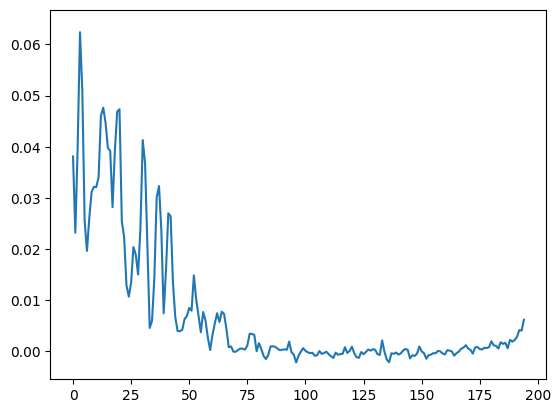

In [107]:
model.eval()
with torch.no_grad():
    z = model.encoder(train_dataset[:100].to(device))  # Check first 100 samples
print("Latent stats:", z.mean(), z.std()) 

x_hat = model(train_dataset[:1].to(device))[0].cpu().detach().numpy()
plt.plot(train_dataset[0], label="Original")
plt.plot(x_hat, label="Reconstructed")
plt.show()

Non-linear spectral functions shape: (20, 195)


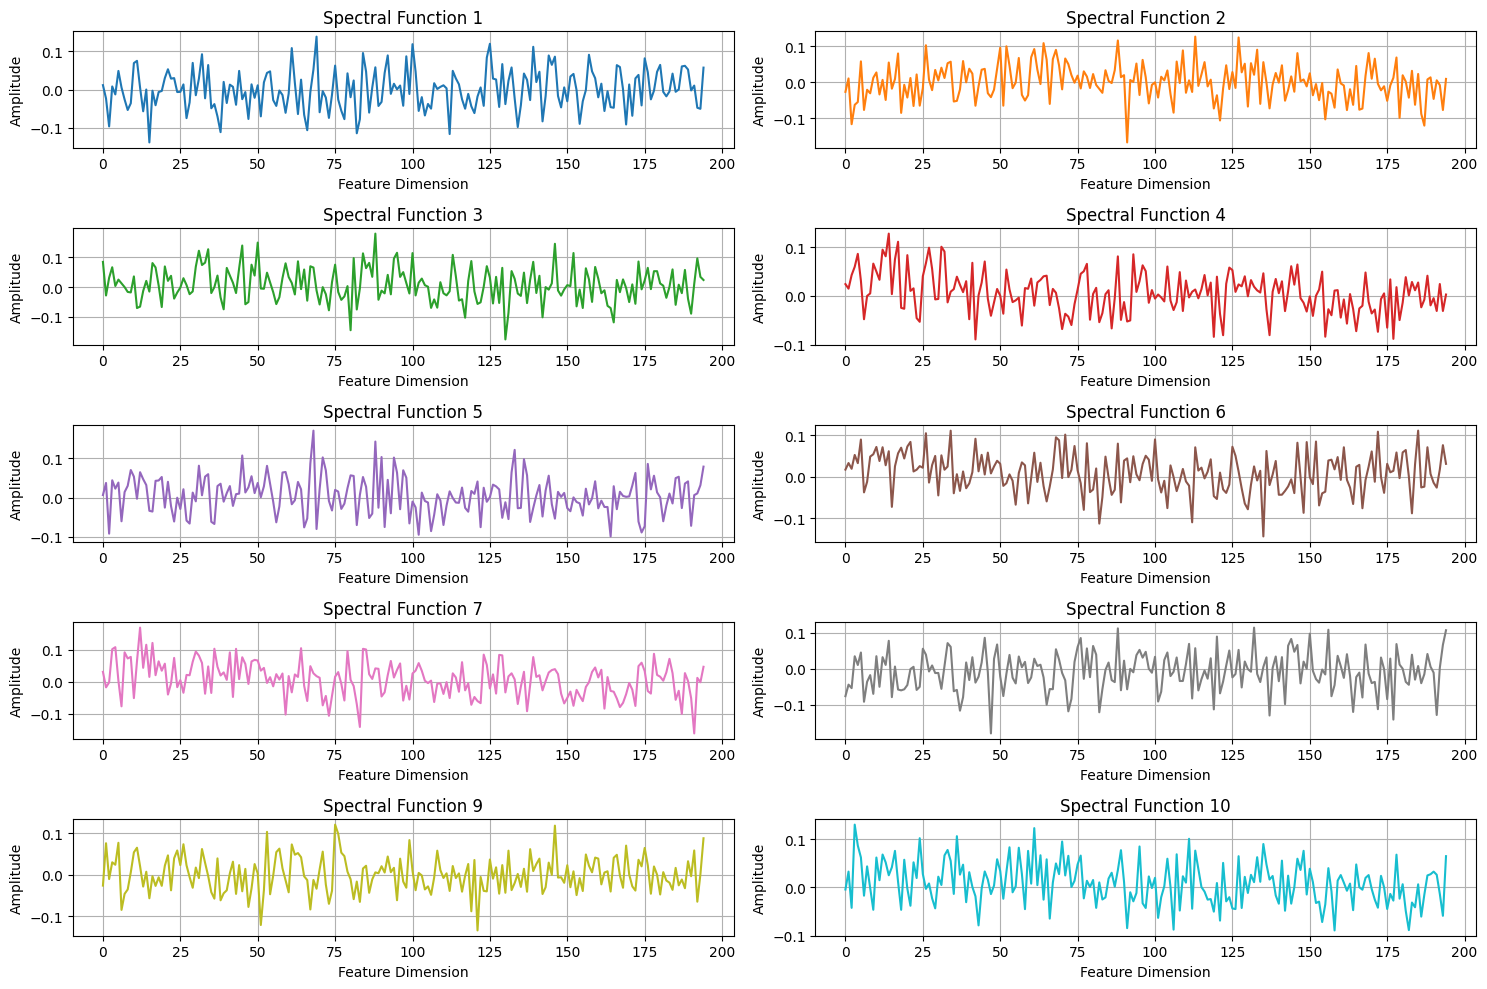

In [108]:
model.eval()
with torch.no_grad():
    # Create latent basis vectors (like PCA components)
    latent_basis = torch.eye(20, device=device)  # Shape: [10, 10]
    
    # Decode to get non-linear spectral functions
    spectral_functions = model.decoder(latent_basis).cpu().numpy()  # Shape: [10, 195]

print("Non-linear spectral functions shape:", spectral_functions.shape)
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns
    plt.plot(spectral_functions[i], color=f'C{i}')
    plt.title(f'Spectral Function {i+1}')
    plt.xlabel('Feature Dimension')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()



Variance explained by each spectral function:
Spectral Function 1: 0.0035 (0.35%)
Spectral Function 2: 0.0030 (0.30%)
Spectral Function 3: 0.0138 (1.38%)
Spectral Function 4: 0.0560 (5.60%)
Spectral Function 5: 0.0070 (0.70%)
Spectral Function 6: 0.0375 (3.75%)
Spectral Function 7: 0.0989 (9.89%)
Spectral Function 8: 0.0146 (1.46%)
Spectral Function 9: 0.0007 (0.07%)
Spectral Function 10: 0.0335 (3.35%)
Spectral Function 11: 0.0205 (2.05%)
Spectral Function 12: 0.0062 (0.62%)
Spectral Function 13: 0.0444 (4.44%)
Spectral Function 14: 0.1168 (11.68%)
Spectral Function 15: 0.0001 (0.01%)
Spectral Function 16: 0.0025 (0.25%)
Spectral Function 17: 0.0932 (9.32%)
Spectral Function 18: 0.0170 (1.70%)
Spectral Function 19: 0.0030 (0.30%)
Spectral Function 20: 0.0611 (6.11%)


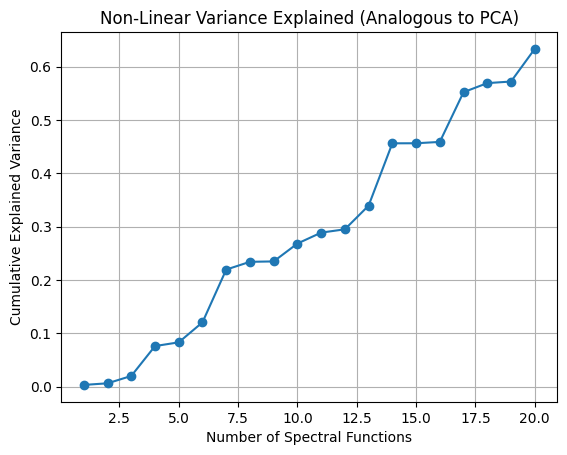

In [110]:
# Center your data (assuming X_train shape: [400, 195])
tau_centered = tau - tau.mean(axis=0)

spectral_functions_normalized = spectral_functions / np.linalg.norm(spectral_functions, axis=1, keepdims=True)

# Project data onto spectral functions (dot product)
projections = np.dot(tau_centered, spectral_functions.T)  # Shape: [400, 10]

# Compute variance captured by each spectral function
variance_contributions = np.var(projections, axis=0)  # Shape: [10]
total_variance = np.var(tau_centered, axis=0).sum()
explained_variance_ratio = variance_contributions / total_variance

print("Variance explained by each spectral function:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Spectral Function {i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, 21), cumulative_variance, marker='o')
plt.xlabel("Number of Spectral Functions")
plt.ylabel("Cumulative Explained Variance")
plt.title("Non-Linear Variance Explained (Analogous to PCA)")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Frequency')

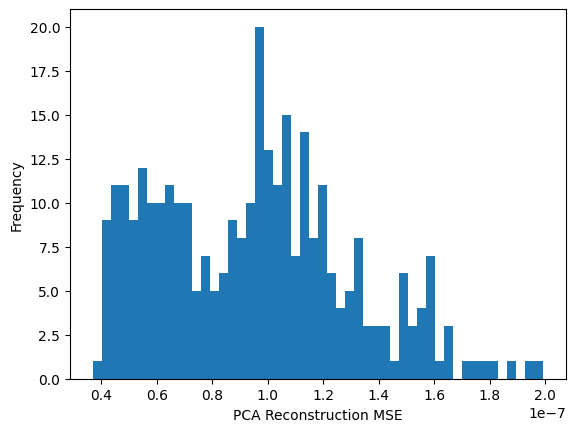

In [111]:
# Compute PCA reconstruction error per sample
pca = PCA(n_components=10)
X_pca = pca.fit_transform(tau)
X_reconstructed = pca.inverse_transform(X_pca)
mse = np.mean((tau - X_reconstructed) ** 2, axis=1)

# Plot residuals
plt.hist(mse, bins=50)
plt.xlabel("PCA Reconstruction MSE")
plt.ylabel("Frequency")

In [22]:
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# latent_tsne = tsne.fit_transform(latent_np)

# plt.figure(figsize=(8,6))
# plt.scatter(latent_tsne[:,0], latent_tsne[:,1], alpha=0.7)
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.title("Latent Space Visualization (t-SNE)")
# plt.show()

In [43]:
##SIF-retrieval 

In [23]:
#SOLAR IRRADIANCE FROM ? 
E = nc.Dataset('S5P_OPER_REF_SOLAR__00000000T000000_99999999T999999_20210107T132455.nc')
groups = E.groups
E_0 = E.groups['band_6']

wavelength = E_0["wavelength"][:]
indices = np.where((wavelength >= 734) & (wavelength <= 758))[0]
# Get irradiance_flux and subset the desired range
irradiance_flux = E_0["irradiance_flux_cf"][0, indices]
num_pixels = len(irradiance_flux)
target_size = 195
step = num_pixels // target_size  
# Average over non-overlapping groups of ground pixels
irradiance_vector = np.squeeze(np.mean(irradiance_flux[:step*target_size].reshape(target_size, step, -1), axis=1))

#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
            """
            Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹.
           
            Parameters:
                irradiance_mol (array): Irradiance in mol s⁻¹ m⁻² nm⁻¹
                wavelength_nm (array): Corresponding wavelengths in nm
               
            Returns:
                array: Irradiance in W m⁻² nm⁻¹
            """
            # Constants
            h = 6.626e-34  # Planck's constant (J·s)
            c = 2.998e8    # Speed of light (m/s)
            Na = 6.022e23  # Avogadro's number (photons/mol)
           
            wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to meters
            photon_energy = (h * c) / wavelength_m  # Energy per photon in Joules
            irradiance_watts = irradiance_mol * Na * photon_energy  # Convert to W/m²/nm
       
            # # Print a value before and after conversion
            # index = 0  # View the first value
            # print(f"Before: {irradiance_mol[index]:.5e} mol/s/m²/nm at {wavelength_nm[index]} nm")
            # print(f"After:  {irradiance_watts[index]:.5f} W/m²/nm at {wavelength_nm[index]} nm")
       
            return irradiance_watts
       
solspec = convert_irradiance(irradiance_vector, wl[ind])

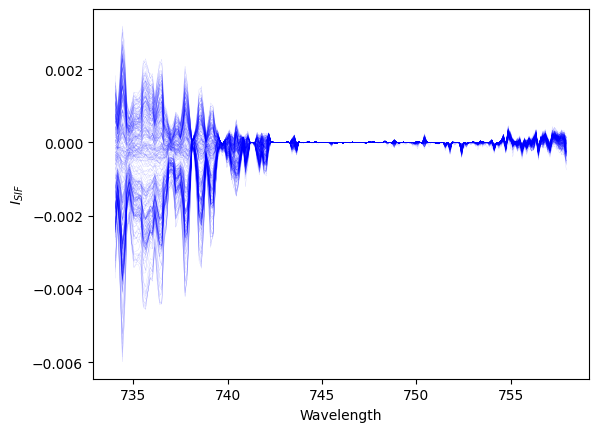

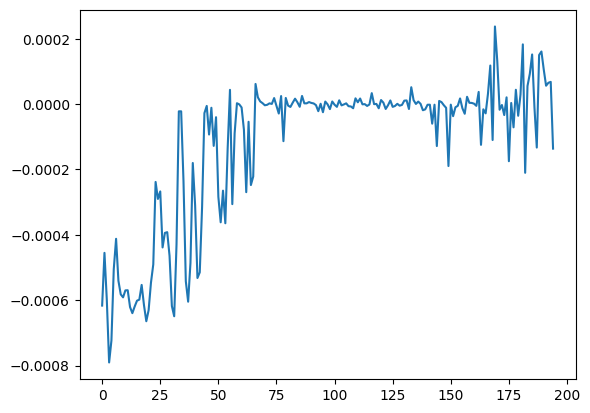

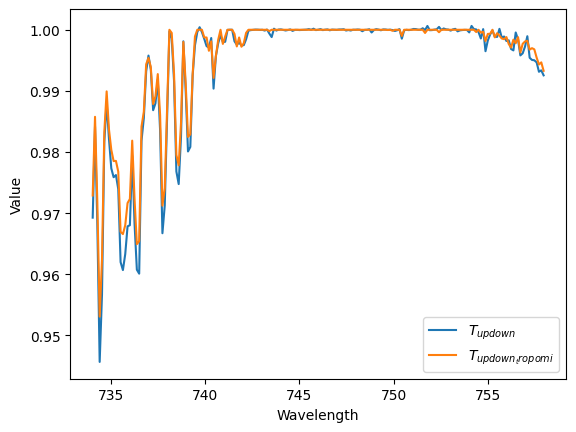

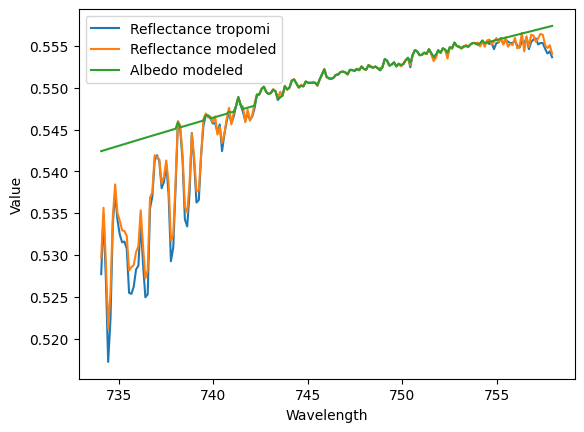

In [24]:
irradiance_matrix = np.tile(solspec.T, (len(scanline_nocloud), 1))
transmitance_matrix = np.exp(-(np.reciprocal(mu_matrix)+ np.reciprocal(mu_0_matrix))*(latent_mean))
up_transmitance_matrix = np.exp(-(latent_mean)/mu_matrix*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))

#this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
diff = reflectance_matrix - surf_albedo*transmitance_matrix
I =irradiance_matrix*mu_0_matrix*(np.round(diff,decimals=10))/(up_transmitance_matrix*math.pi) #is E_0 correct??? irradiance_matrix* I removed this as it was too large 50-100!!!
for n in range(len(scanline_nocloud)):
    plt.plot(wl[ind],I[n], color = "blue", alpha=0.2, linewidth=0.2)
plt.xlabel('Wavelength')
plt.ylabel("$I_{SIF}$")
#plt.savefig("SIF_retrieved_africa_irrad")
plt.show()
plt.plot(I.mean(axis = 0))
plt.show()
up_transmitance_tropomi = np.exp(-tau/mu_matrix*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))*tau)[100]
modeled_reflectance = surf_albedo*transmitance_tropomi + up_transmitance_matrix*math.pi*I/(irradiance_matrix*mu_0_matrix)

plt.plot(wl[ind], transmitance_matrix[100], label="$T_{updown}$")
plt.plot(wl[ind],transmitance_tropomi , label="$T_{updown_tropomi}$")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()

plt.plot(wl[ind], reflectance_matrix[100], label="Reflectance tropomi")
plt.plot(wl[ind], modeled_reflectance[100], label="Reflectance modeled")
plt.plot(wl[ind], surf_albedo[100], label="Albedo modeled")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()



In [13]:
h2 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T172817_20240206T173755_32735_93_000001_20241120T172637.nc')
africa2 = h2.groups['africa']

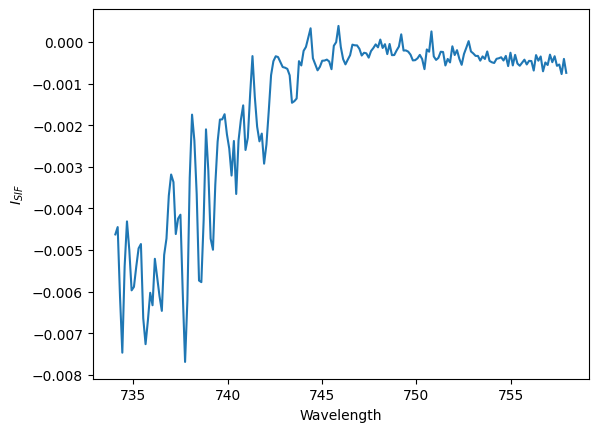

In [14]:
#Identify scanline in groundpixel 224 with clouds
scanline2 = africa2.variables['scanline']
groundpixel2 = africa2.variables['ground_pixel']
scanline_nocloud2 = []
for n in range(406):
    if africa2.variables['CloudFraction'][0,n,224]<0.5:
        scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#sc_nc > sc_nc2

#Fixing albedo 

ref_na2 = africa2.variables["Reflectance"][0, scanline_nocloud2, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 195))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb + 0.007

#Computing tau
mu2 = np.cos(np.radians(africa2.variables["VZA"][0,scanline_nocloud2,224]))
mu_02 = np.cos(np.radians(africa2.variables["SZA"][0,scanline_nocloud2,224]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,195))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 195))
reflectance_matrix2 = africa2.variables['Reflectance'][0, scanline_nocloud2, 224, 276:471]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))
irradiance_matrix2 = np.tile(solspec.T, (len(scanline_nocloud2), 1))

transmitance_matrix2 = np.exp(-(np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))*latent_mean)
up_transmitance_matrix2 = np.exp(-(np.reciprocal(mu_matrix2)/(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2)))*latent_mean/mu_matrix2)
#this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
diff2 = reflectance_matrix2 - surf_alb2*transmitance_matrix2
I2 = irradiance_matrix2*mu_0_matrix2*(np.round(diff2, decimals=10))/(up_transmitance_matrix2*math.pi) #this I is really I/E_0  irradiance_matrix*
plt.plot(wl[ind],I2[0])
#plt.plot(wl[ind], africa2.variables['Reflectance'][0, 200, 224, 276:471].data)
plt.xlabel('Wavelength')
plt.ylabel("$I_{SIF}$")
#plt.savefig("retrieved_SIF_amazonas_irrad")
plt.show()

In [18]:
irradiance_matrix2 = np.tile(solspec.T, (len(scanline_nocloud), 1))
reflectance_map = africa2.variables['Reflectance'][0, scanline_nocloud2, 0:448, 276:471] 
diff2 = reflectance_map - (surf_alb2 * transmitance_matrix2)[:, None, :]

SIF= (irradiance_matrix2[:, None] * mu_0_matrix2[:, None] * 
     np.round(diff2, decimals=10)) / (up_transmitance_matrix2[:,None] * np.pi)

ValueError: operands could not be broadcast together with shapes (358,1,195) (333,1,195) 

In [ ]:
SIF_va = np.stack(SIF)
ground_pixel2 = africa2.variables['ground_pixel'][:]
scanline2 = africa2.variables['scanline'][scanline_nocloud2]
# Plot SIF over the Amazonas 448 groundpixels and 406 scanlines
plt.imshow(SIF_va[:,:,100].data, origin='lower')
plt.colorbar(label='SIF')
plt.xlabel('Ground Pixel')
plt.ylabel('Scanline')
plt.title('SIF at First Spectral Channel at time 0')
#plt.savefig('sif_colour.png')
plt.show()
SIF_va.shape